# Installing Packages

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from PIL import Image
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model

# Model 1 : Custom CNN from Scratch

## Initializing the ImageGenerators

In [ ]:
# Define paths to the train and validation directories
train_data_dir = '/content/train'
test_data_dir = '/content/test'

In [ ]:
# Set some parameters
img_width, img_height = 48, 48  # Size of images
batch_size = 64
epochs = 10
num_classes = 7  # Update this based on the number of your classes

In [ ]:
# Rescale the pixel values (0-255) to the [0, 1] interval
data_generator = ImageDataGenerator(rescale=1./255,
                                    validation_split=0.2)

# Automatically retrieve images and their classes for train and validation sets
train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training')

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation')

test_generator = data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',)
    # subset='validation')

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
# Accessing class labels for the training data
train_class_labels = train_generator.class_indices
print("Training class labels:", train_class_labels)

# Accessing class labels for the validation data
validation_class_labels = validation_generator.class_indices
print("Validation class labels:", validation_class_labels)

# Accessing class labels for the validation data
test_class_labels = test_generator.class_indices
print("Validation class labels:", test_class_labels)

Training class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Validation class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Validation class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [ ]:
# Initialising the CNN
model = Sequential()

# Adding convolutional layers with activations on the same line for clarity
model.add(Conv2D(32, kernel_size=(3, 3),kernel_initializer="glorot_uniform", padding='same', input_shape=(img_width, img_height, 1)))
model.add(Activation('relu'))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(256, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening and adding dense layers
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                     

In [ ]:
# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                     

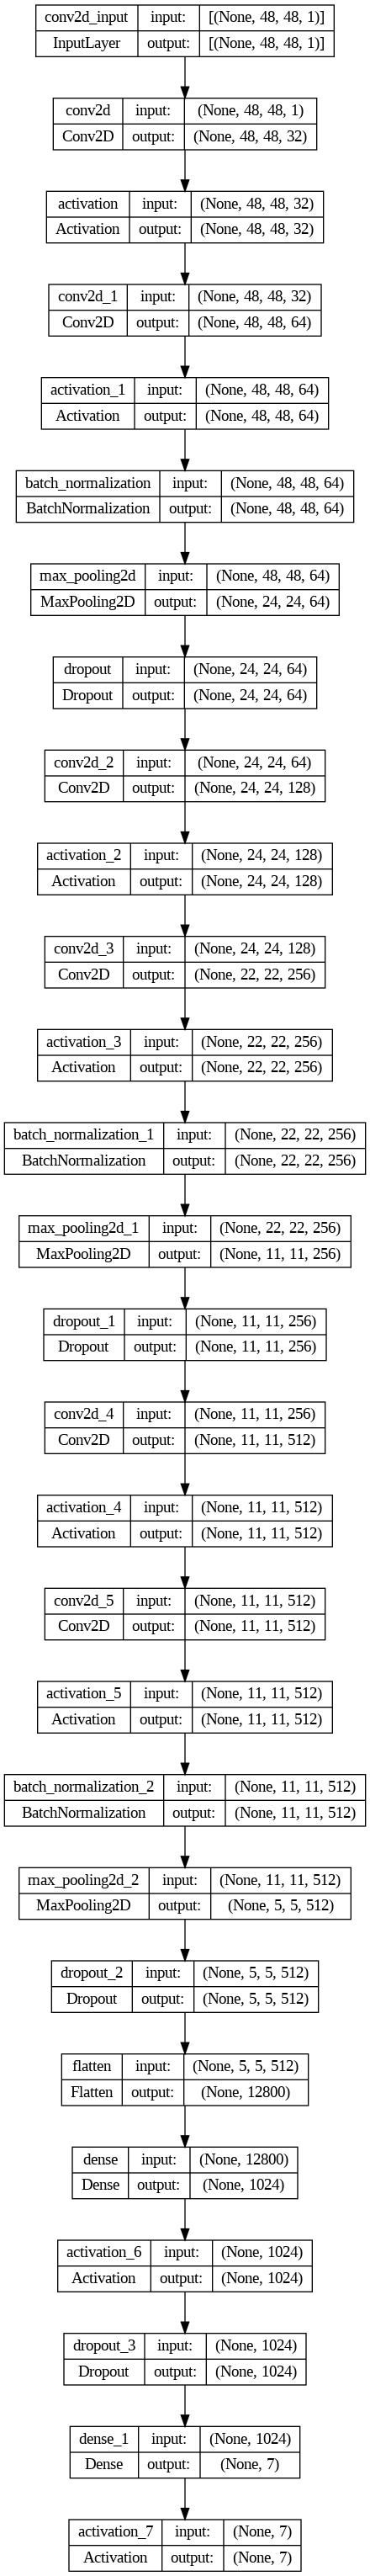

In [ ]:
plot_model(model, to_file = '/content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Architecture.png',
           show_shapes=True, show_layer_names=True)

# Understanding Callbacks

In [ ]:
# File path for the model checkpoint
cnn_path = '/content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch'
name = 'Custom_CNN_model.keras'
chk_path = os.path.join(cnn_path, name)
chk_path

'/content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_model.keras'

In [ ]:
# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

In [ ]:
# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

In [ ]:
# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

In [ ]:
# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

In [ ]:
# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]  # Adjusted as per your use-case

# Calculating Steps for epoch

In [ ]:
train_generator.samples

22968

In [ ]:
train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

# Model Training

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_steps_epoch,
    callbacks=callbacks)

Epoch 1/10
359/359 [==============================] - ETA: 0s - loss: 12.4396 - accuracy: 0.2740
Epoch 1: val_loss improved from inf to 13.51567, saving model to /content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_model.keras
359/359 [==============================] - 40s 81ms/step - loss: 12.4396 - accuracy: 0.2740 - val_loss: 13.5157 - val_accuracy: 0.1735 - lr: 1.0000e-04
Epoch 2/10
359/359 [==============================] - ETA: 0s - loss: 10.2490 - accuracy: 0.3507
Epoch 2: val_loss improved from 13.51567 to 9.49665, saving model to /content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_model.keras
359/359 [==============================] - 26s 71ms/step - loss: 10.2490 - accuracy: 0.3507 - val_loss: 9.4966 - val_accuracy: 0.3904 - lr: 1.0000e-04
Epoch 3/10
359/359 [==============================] - ETA: 0s - loss: 8.2320 - accuracy: 0.3958
Epoch 3: val_loss improved from 9.49665 to 7.67904, saving model to /content/FER_2013_Emotion_Detection/Cus

# Plotting Performance Metrics

In [ ]:
def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss.

    Parameters:
    - history: A Keras History object. Contains the logs from the training process.

    Returns:
    - None. Displays the matplotlib plots for training/validation accuracy and loss.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(20, 5))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

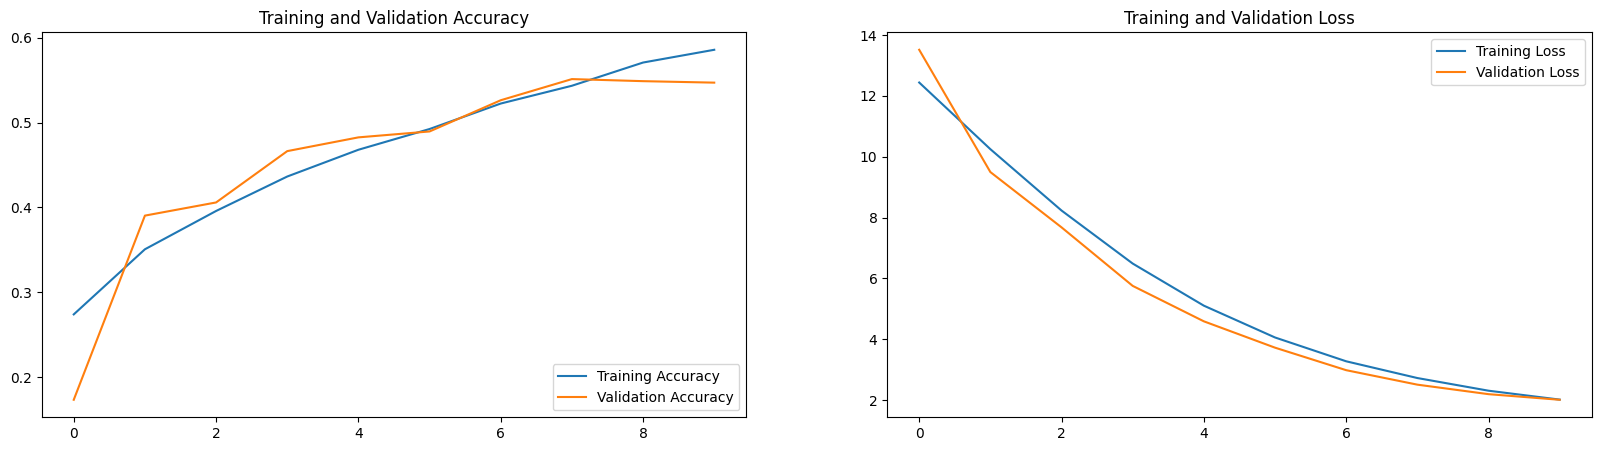

In [ ]:
plot_training_history(history)

# Model Evaluation

In [ ]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 3s 27ms/step - loss: 2.0106 - accuracy: 0.5552
final train accuracy = 63.11 , validation accuracy = 55.52


# Plotting Confusion Matrix

113/113 [==============================] - 4s 35ms/step


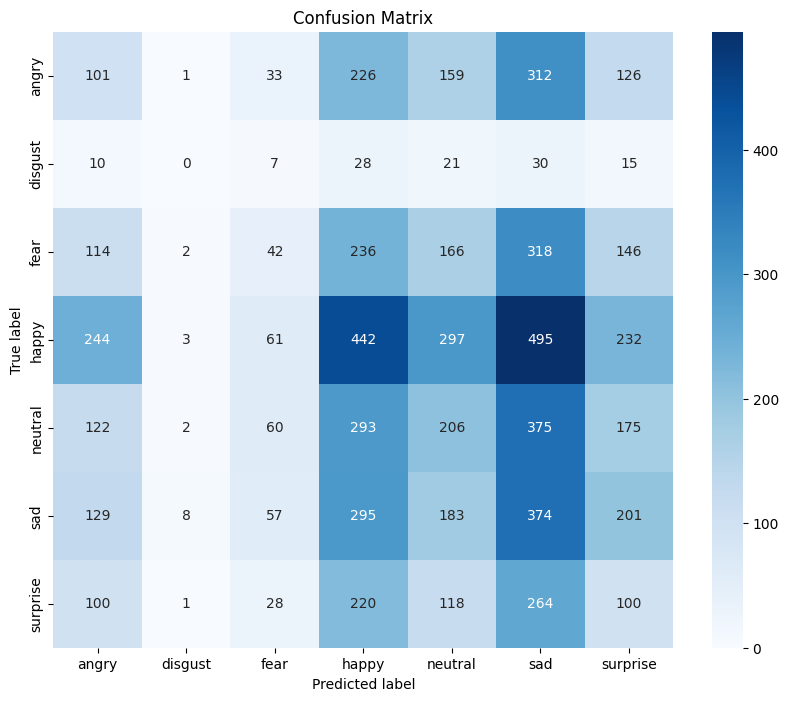

In [ ]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# Printing the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.12      0.11      0.11       958
     disgust       0.00      0.00      0.00       111
        fear       0.15      0.04      0.06      1024
       happy       0.25      0.25      0.25      1774
     neutral       0.18      0.17      0.17      1233
         sad       0.17      0.30      0.22      1247
    surprise       0.10      0.12      0.11       831

    accuracy                           0.18      7178
   macro avg       0.14      0.14      0.13      7178
weighted avg       0.17      0.18      0.17      7178



# Making Predictions

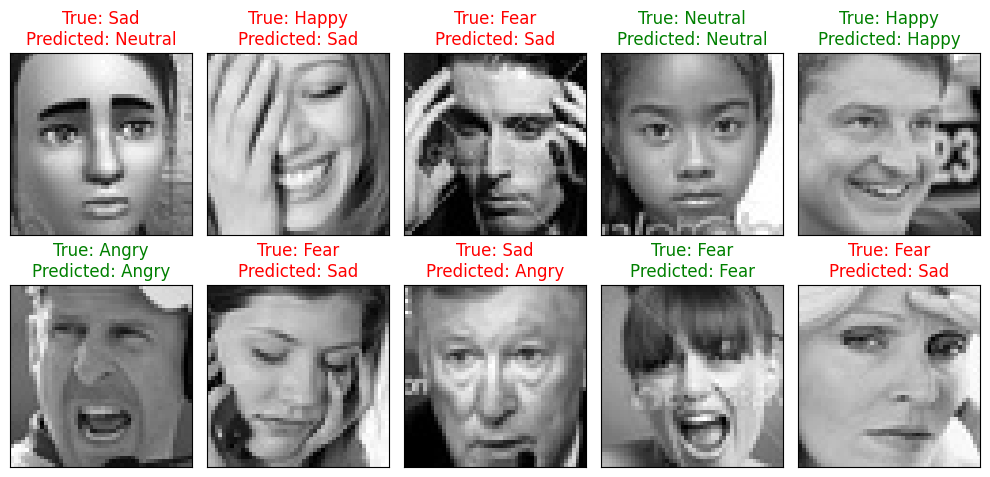

In [ ]:
# Emotion classes for the dataset
Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Assuming test_generator and model are already defined
batch_size = test_generator.batch_size

# Selecting a random batch from the test generator
Random_batch = np.random.randint(0, len(test_generator) - 1)

# Selecting random image indices from the batch
Random_Img_Index = np.random.randint(0, batch_size, 10)

# Setting up the plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    # Fetching the random image and its label
    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]], axis=0)

    # Making a prediction using the model
    Model_Prediction = np.argmax(model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0), axis=1)[0]

    # Displaying the image
    ax.imshow(Random_Img.squeeze(), cmap='gray')  # Assuming the images are grayscale
    # Setting the title with true and predicted labels, colored based on correctness
    color = "green" if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction] else "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()

# Model 2: Image Augmentation

In [ ]:
# Define paths to the train and validation directories
train_data_dir = '/content/train'
test_data_dir = '/content/test'
# validation_data_dir = '/content/emotion_detection_project/datasets/raw/test'

# Set some parameters
img_width, img_height = 48, 48  # Size of images
batch_size = 64
epochs = 10
num_classes = 7  # Update this based on the number of your classes


# Initializing the ImageDataGenerator with data augmentation options for the training set
data_generator = ImageDataGenerator(
    rescale=1./255,  # Rescale the pixel values from [0, 255] to [0, 1]
    rotation_range=40,  # Degree range for random rotations
    width_shift_range=0.2,  # Range (as a fraction of total width) for random horizontal shifts
    height_shift_range=0.2,  # Range (as a fraction of total height) for random vertical shifts
    shear_range=0.2,  # Shearing intensity (shear angle in counter-clockwise direction)
    zoom_range=0.2,  # Range for random zoom
    horizontal_flip=True,  # Randomly flip inputs horizontally
    fill_mode='nearest',  # Strategy to fill newly created pixels, which can appear after a rotation or a width/height shift
    validation_split=0.2  # Set the validation split; 20% of the data will be used for validation
)

test_data_generator = ImageDataGenerator(rescale=1./255)


# Automatically retrieve images and their classes for train and validation sets
train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training')

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation')

test_generator = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
    )

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


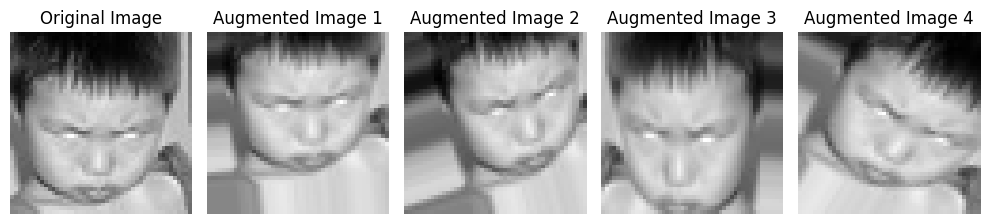

In [ ]:
# Path to your specific image
image_path = '/content/train/angry/Training_10118481.jpg'

# Load and convert the image to an array
img = load_img(image_path, color_mode='grayscale', target_size=(img_width, img_height))  # Adjust color_mode if necessary
img_array = img_to_array(img)  # Converts the image to a numpy array
img_array = img_array.reshape((1,) + img_array.shape)  # Reshapes the image to (1, width, height, channels) for the generator

# Setting up the plot
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 4))
# Plot the original image first. Since img_array is a 3D array after reshaping, we use [:, :, 0]
axes[0].imshow(img_array[0, :, :, 0], cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Generate and plot augmented images
for i, ax in enumerate(axes.flat[1:]):  # Start from the second subplot
    # Generate a batch of augmented images
    aug_iter = data_generator.flow(img_array, batch_size=1)
    aug_img = next(aug_iter)[0]  # Get the first augmented image from the batch

    # Plot the augmented image. We directly use [:, :, 0] without an initial batch index
    ax.imshow(aug_img[:, :, 0], cmap='gray')
    ax.set_title(f'Augmented Image {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Same CNN Model as above

In [ ]:
# Assuming img_width, img_height, and classes are defined. For example:
img_width, img_height = 48, 48
classes = 7

#Initialising the CNN
model = tf.keras.models.Sequential()

# Adding convolutional layers with activations on separate lines
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', input_shape=(img_width, img_height, 1)))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(256, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening and adding dense layers
model.add(Flatten())
model.add(Dense(1024))
model.add(tf.keras.layers.Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(classes))
model.add(tf.keras.layers.Activation('softmax'))

# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# File path for the model checkpoint
cnn_path = '/content/FER_2013_Emotion_Detection/Custom_CNN_With_Augmentation'
name = 'Custom_CNN_augmented_model.keras'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]  # Adjusted as per your use-case

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_steps_epoch,
    callbacks=callbacks)

Epoch 1/100
359/359 [==============================] - ETA: 0s - loss: 12.4896 - accuracy: 0.2188
Epoch 1: val_loss improved from inf to 14.14767, saving model to /content/FER_2013_Emotion_Detection/Custom_CNN_With_Augmentation/Custom_CNN_augmented_model.keras
359/359 [==============================] - 37s 87ms/step - loss: 12.4896 - accuracy: 0.2188 - val_loss: 14.1477 - val_accuracy: 0.1681 - lr: 1.0000e-04
Epoch 2/100
359/359 [==============================] - ETA: 0s - loss: 10.2419 - accuracy: 0.2406
Epoch 2: val_loss improved from 14.14767 to 10.43937, saving model to /content/FER_2013_Emotion_Detection/Custom_CNN_With_Augmentation/Custom_CNN_augmented_model.keras
359/359 [==============================] - 32s 90ms/step - loss: 10.2419 - accuracy: 0.2406 - val_loss: 10.4394 - val_accuracy: 0.2284 - lr: 1.0000e-04
Epoch 3/100
359/359 [==============================] - ETA: 0s - loss: 8.1725 - accuracy: 0.2461
Epoch 3: val_loss improved from 10.43937 to 7.88726, saving model to /co

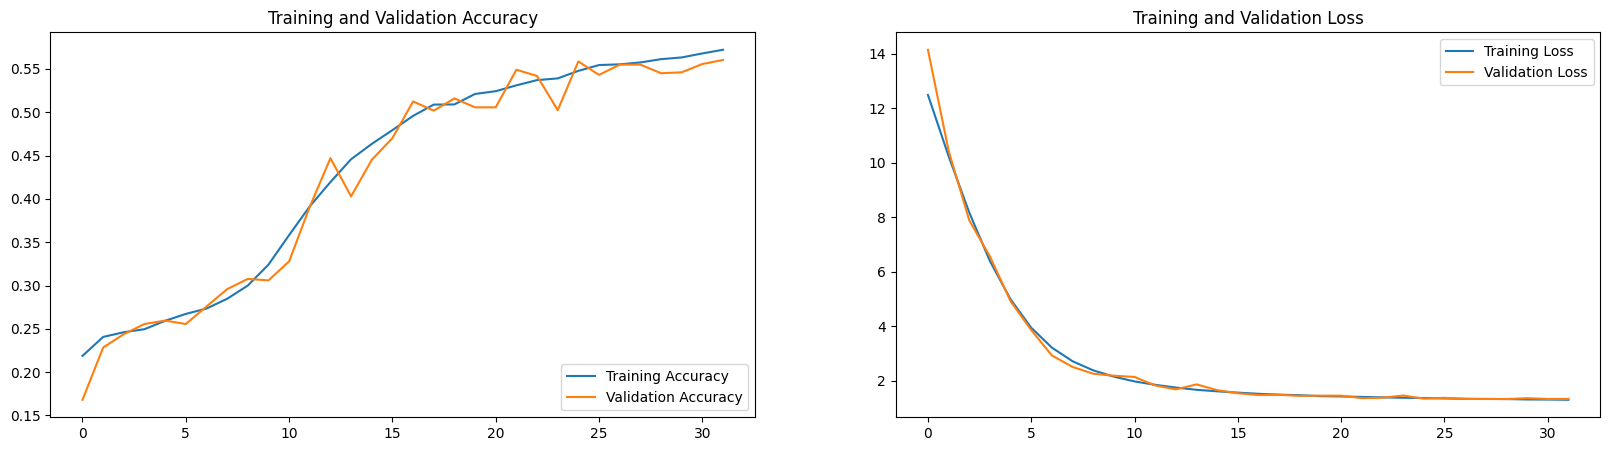

In [ ]:
plot_training_history(history)

In [ ]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 3s 24ms/step - loss: 1.2292 - accuracy: 0.5928
final train accuracy = 57.64 , validation accuracy = 59.28


113/113 [==============================] - 3s 22ms/step


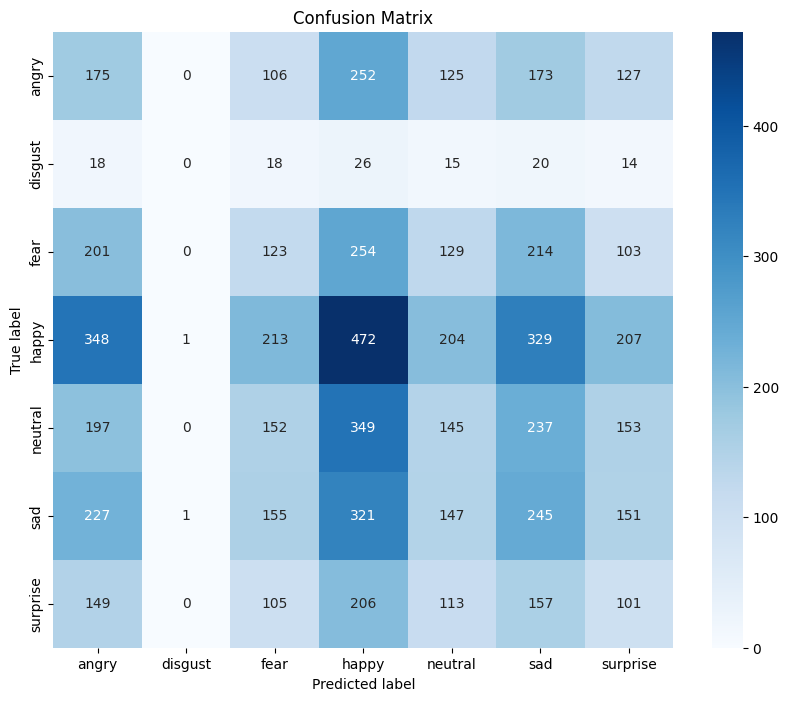

In [ ]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# Printing the classification report
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.14      0.04      0.06       958
     disgust       0.00      0.00      0.00       111
        fear       0.14      0.03      0.05      1024
       happy       0.25      0.23      0.24      1774
     neutral       0.17      0.23      0.19      1233
         sad       0.18      0.35      0.24      1247
    surprise       0.13      0.13      0.13       831

    accuracy                           0.18      7178
   macro avg       0.14      0.15      0.13      7178
weighted avg       0.17      0.18      0.16      7178



# Model 3: Transfer Learning VGGNET

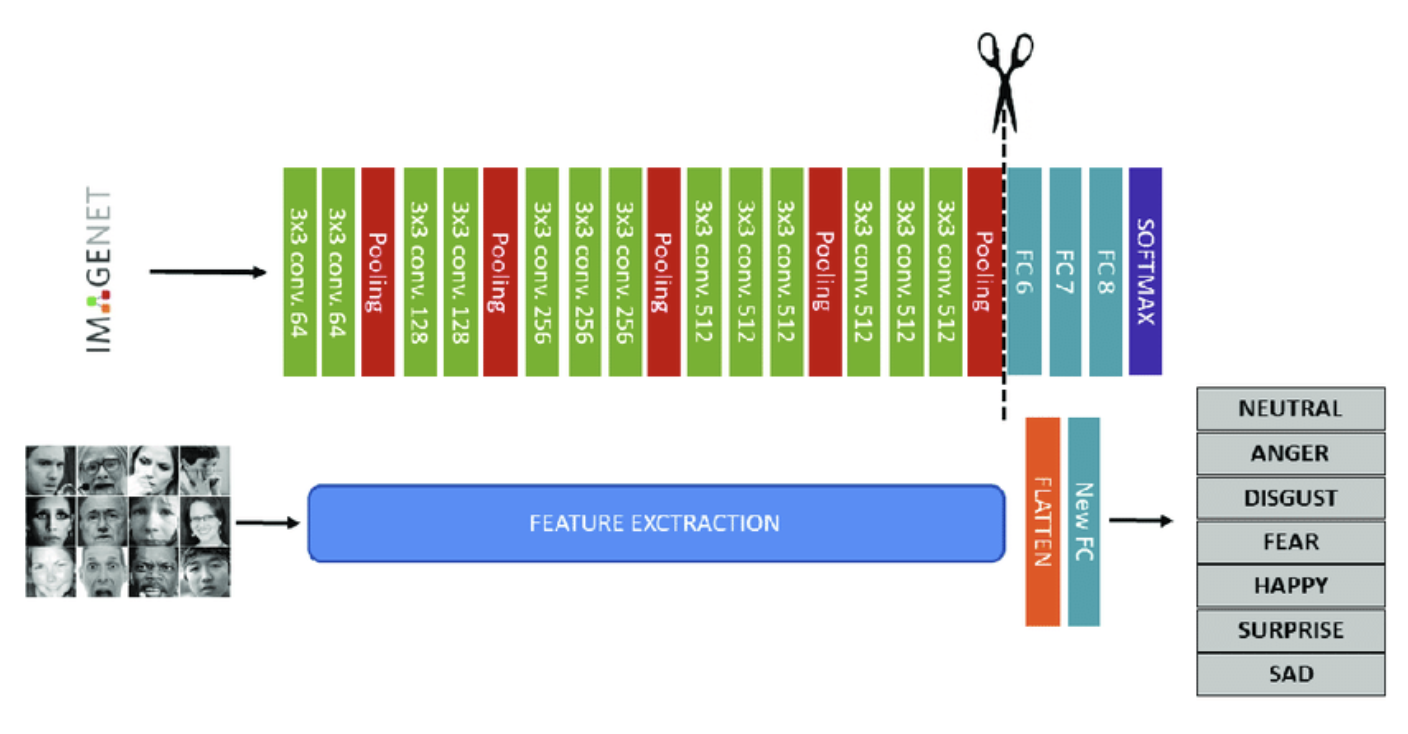

In [ ]:
# Define paths to the train and validation directories
train_data_dir = '/content/train'
test_data_dir = '/content/test'

# validation_data_dir = '/content/emotion_detection_project/datasets/raw/test'

# Set some parameters
img_width, img_height = 224, 224  # Size of images
batch_size = 64
epochs = 10
num_classes = 7  # Update this based on the number of your classes

# Rescale the pixel values (0-255) to the [0, 1] interval
data_generator = ImageDataGenerator(
                                rescale = 1 / 255.,
                                rotation_range=10,
                                zoom_range=0.2,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                horizontal_flip=True,
                                fill_mode='nearest',
                                # validation_split=0.2
                                )

test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

# Automatically retrieve images and their classes for train and validation sets
train_generator = data_generator.flow_from_directory(
                                train_data_dir,
                                target_size=(img_width, img_height),
                                batch_size=batch_size,
                                class_mode='categorical',
                                color_mode='rgb',
                                subset='training',
                                shuffle = True)

test_generator = test_preprocessor.flow_from_directory(
                                test_data_dir,
                                target_size=(img_width, img_height),
                                batch_size=batch_size,
                                class_mode='categorical',
                                color_mode='rgb',)
                                # subset='validation')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
# Extract class labels for all instances in the training dataset
classes = np.array(train_generator.classes)

# Calculate class weights to handle imbalances in the training data
# 'balanced' mode automatically adjusts weights inversely proportional to class frequencies
class_weights = compute_class_weight(
    class_weight='balanced',  # Strategy to balance classes
    classes=np.unique(classes),  # Unique class labels
    y=classes  # Class labels for each instance in the training dataset
)

# Create a dictionary mapping class indices to their calculated weights
class_weights_dict = dict(enumerate(class_weights))

# Output the class weights dictionary
print("Class Weights Dictionary:", class_weights_dict)

Class Weights Dictionary: {0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [ ]:
classes = 7

# Clear the previous TensorFlow sessionx
tf.keras.backend.clear_session()

# Load the VGG16 base model, excluding its top (fully connected) layers
vgg = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
vgg.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
# Make the specified layers non-trainable
for layer in vgg.layers[:-3]:
    layer.trainable = False

vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
classes

array([0, 0, 0, ..., 6, 6, 6], dtype=int32)

In [ ]:
# Flattening the layer and adding custom Dense layers
x = Flatten()(vgg.output)

# Adding a fully connected layer with ReLU activation and He normal initializer
x = Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization

x = Dense(512, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization

# Adding the output layer with softmax activation
# Note: Adjust the number of units to match the number of classes you have
output = Dense(7, activation='softmax', kernel_initializer='he_normal')(x)

# Creating the model
model = Model(inputs=vgg.input, outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False),
              metrics=['accuracy'])

# Model summary to see all layers
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# File path for the model checkpoint
cnn_path = '/content/FER_2013_Emotion_Detection/VGG16_Transfer_Learning'
name = 'VGG16_Transfer_Learning.keras'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]  # Adjusted as per your use-case

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
# validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [ ]:
history = model.fit(
                    train_generator,
                    steps_per_epoch=train_steps_per_epoch,
                    epochs=50,
                    validation_data=test_generator,
                    validation_steps=test_steps_epoch,
                    class_weight=class_weights_dict,
                    callbacks = callbacks
                    )

Epoch 1/50
449/449 [==============================] - ETA: 0s - loss: 1.8374 - accuracy: 0.2601
Epoch 1: val_loss improved from inf to 1.47277, saving model to /content/FER_2013_Emotion_Detection/VGG16_Transfer_Learning/VGG16_Transfer_Learning.keras
449/449 [==============================] - 436s 933ms/step - loss: 1.8374 - accuracy: 0.2601 - val_loss: 1.4728 - val_accuracy: 0.4401 - lr: 1.0000e-04
Epoch 2/50
449/449 [==============================] - ETA: 0s - loss: 1.6075 - accuracy: 0.3841
Epoch 2: val_loss improved from 1.47277 to 1.39369, saving model to /content/FER_2013_Emotion_Detection/VGG16_Transfer_Learning/VGG16_Transfer_Learning.keras
449/449 [==============================] - 433s 963ms/step - loss: 1.6075 - accuracy: 0.3841 - val_loss: 1.3937 - val_accuracy: 0.4698 - lr: 1.0000e-04
Epoch 3/50
449/449 [==============================] - ETA: 0s - loss: 1.4904 - accuracy: 0.4273
Epoch 3: val_loss did not improve from 1.39369
449/449 [==============================] - 419s 9

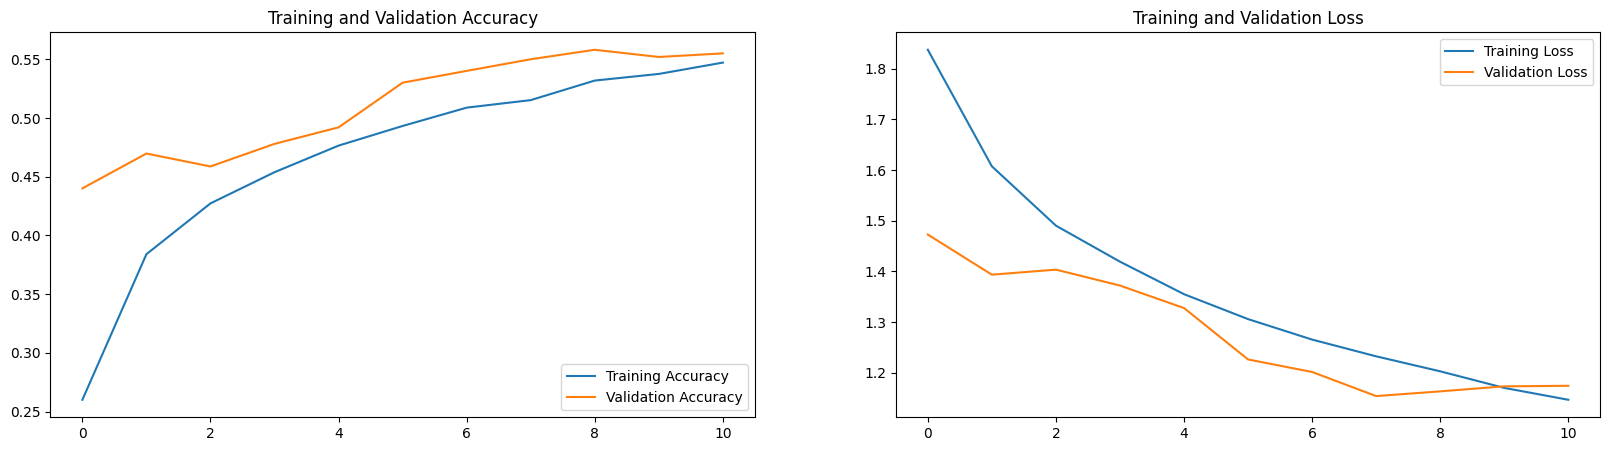

In [ ]:
plot_training_history(history)

In [ ]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 29s 257ms/step - loss: 1.1542 - accuracy: 0.5500
final train accuracy = 55.93 , validation accuracy = 55.00


113/113 [==============================] - 28s 250ms/step


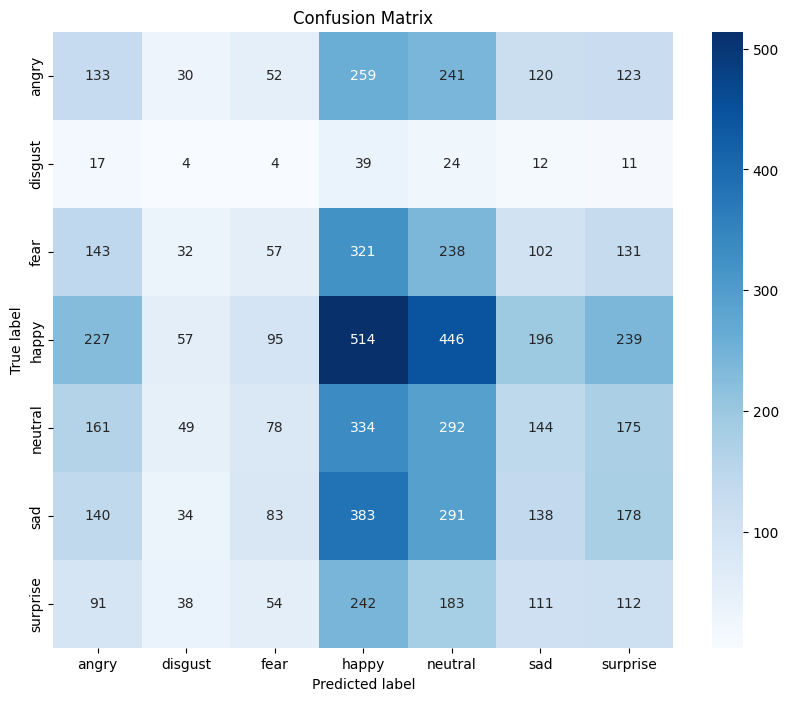

In [ ]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# Printing the classification report
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.15      0.14      0.14       958
     disgust       0.02      0.04      0.02       111
        fear       0.13      0.06      0.08      1024
       happy       0.25      0.29      0.27      1774
     neutral       0.17      0.24      0.20      1233
         sad       0.17      0.11      0.13      1247
    surprise       0.12      0.13      0.12       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.17      0.17      7178



# Model 4 : Transfer Leanring - ResNet50

In [ ]:
# Directory paths for training and testing data
train_dir = '/content/train'
test_dir = '/content/test'

# Batch size for data generators
batch_size = 64

# Data augmentation configuration for training data
train_datagen = ImageDataGenerator(
                                  rescale=1 / 255.,  # Rescale pixel values to [0,1]
                                  rotation_range=10,  # Random rotation within range [-10,10] degrees
                                  zoom_range=0.2,  # Random zoom between [0.8, 1.2]
                                  width_shift_range=0.1,  # Random horizontal shift within range [-0.1, 0.1]
                                  height_shift_range=0.1,  # Random vertical shift within range [-0.1, 0.1]
                                  horizontal_flip=True,  # Random horizontal flip
                                  fill_mode='nearest'  # Fill mode for handling newly created pixels
                                 )

# Configuration for testing data (only rescaling)
test_datagen = ImageDataGenerator(
                                  rescale=1 / 255.  # Rescale pixel values to [0,1]
                                 )

# Data generators for training and testing data
train_generator = train_datagen.flow_from_directory(
                                                    train_dir,  # Directory containing training data
                                                    class_mode="categorical",  # Classification mode for categorical labels
                                                    target_size=(224, 224),  # Resize input images to (224,224)
                                                    color_mode='rgb',  # Color mode for images (RGB)
                                                    shuffle=True,  # Shuffle training data
                                                    batch_size=batch_size,  # Batch size for training
                                                    subset='training'  # Subset of data (training)
                                                   )

test_generator = test_datagen.flow_from_directory(
                                                  test_dir,  # Directory containing testing data
                                                  class_mode="categorical",  # Classification mode for categorical labels
                                                  target_size=(224, 224),  # Resize input images to (224,224)
                                                  color_mode="rgb",  # Color mode for images (RGB)
                                                  shuffle=False,  # Do not shuffle testing data
                                                  batch_size=batch_size  # Batch size for testing
                                                 )


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# Introducing Class wieghts for imbalanced data

In [ ]:
# Extract class labels for all instances in the training dataset
classes = np.array(train_generator.classes)

# Calculate class weights to handle imbalances in the training data
# 'balanced' mode automatically adjusts weights inversely proportional to class frequencies
class_weights = compute_class_weight(
    class_weight='balanced',  # Strategy to balance classes
    classes=np.unique(classes),  # Unique class labels
    y=classes  # Class labels for each instance in the training dataset
)

# Create a dictionary mapping class indices to their calculated weights
class_weights_dict = dict(enumerate(class_weights))

# Output the class weights dictionary
print("Class Weights Dictionary:", class_weights_dict)

Class Weights Dictionary: {0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [ ]:
ResNet50V2 = tf.keras.applications.ResNet50V2(input_shape=(224, 224, 3),
                                               include_top= False,
                                               weights='imagenet'
                                               )

94668760/94668760 [==============================] - 1s 0us/step


In [ ]:
# Freezing all layers except last 50

ResNet50V2.trainable = True

for layer in ResNet50V2.layers[:-50]:
    layer.trainable = False

In [ ]:
def Create_ResNet50V2_Model():

    model = Sequential([
                      ResNet50V2,
                      Dropout(0.25),
                      BatchNormalization(),
                      Flatten(),
                      Dense(64, activation='relu'),
                      BatchNormalization(),
                      Dropout(0.5),
                      Dense(7,activation='softmax')
                    ])
    return model

In [ ]:
model = Create_ResNet50V2_Model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 dropout (Dropout)           (None, 7, 7, 2048)        0         
                                                                 
 batch_normalization (Batch  (None, 7, 7, 2048)        8192      
 Normalization)                                                  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 64)                6422592   
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                       

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# File path for the model checkpoint
cnn_path = '/content/FER_2013_Emotion_Detection/ResNet50_Transfer_Learning'
name = 'ResNet50_Transfer_Learning.keras'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor = 'val_accuracy',
                          patience = 7,
                          restore_best_weights = True,
                          verbose=1)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=2,
#                             min_lr=0.00005,
                              verbose=1)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, csv_logger]  # Adjusted as per your use-case

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
# validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [ ]:
train_history = model.fit(
                          train_generator,
                          steps_per_epoch=train_steps_per_epoch,
                          epochs=30,
                          validation_data=test_generator,
                          validation_steps=test_steps_epoch,
                          class_weight=class_weights_dict,
                          callbacks = callbacks
                         )

Epoch 1/30
449/449 [==============================] - ETA: 0s - loss: 1.6660 - accuracy: 0.4095
Epoch 1: val_loss improved from inf to 150.18819, saving model to /content/FER_2013_Emotion_Detection/ResNet50_Transfer_Learning/ResNet50_Transfer_Learning.keras
449/449 [==============================] - 437s 929ms/step - loss: 1.6660 - accuracy: 0.4095 - val_loss: 150.1882 - val_accuracy: 0.2455
Epoch 2/30
449/449 [==============================] - ETA: 0s - loss: 1.3329 - accuracy: 0.5082
Epoch 2: val_loss improved from 150.18819 to 1.21279, saving model to /content/FER_2013_Emotion_Detection/ResNet50_Transfer_Learning/ResNet50_Transfer_Learning.keras
449/449 [==============================] - 388s 864ms/step - loss: 1.3329 - accuracy: 0.5082 - val_loss: 1.2128 - val_accuracy: 0.5534
Epoch 3/30
449/449 [==============================] - ETA: 0s - loss: 1.3546 - accuracy: 0.5145
Epoch 3: val_loss improved from 1.21279 to 1.17167, saving model to /content/FER_2013_Emotion_Detection/ResNet50

KeyboardInterrupt: 

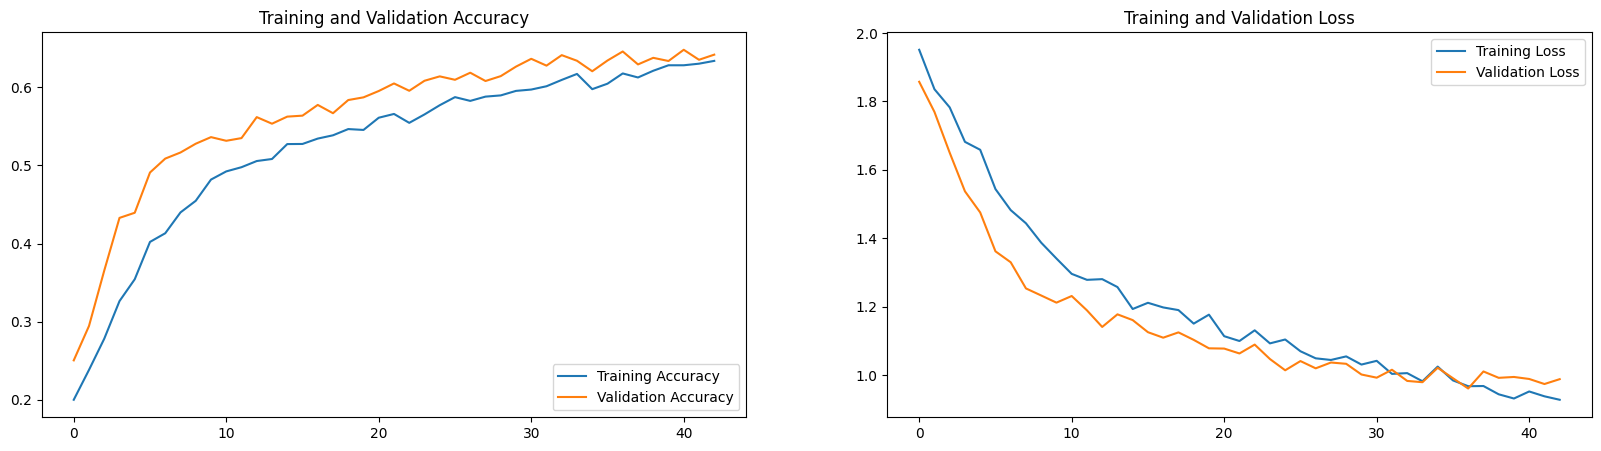

In [ ]:
plot_training_history(train_history)

In [ ]:
import keras

In [ ]:
# model = keras.saving.load_model("/content/FER_2013_Emotion_Detection/ResNet50_Transfer_Learning/ResNet50_Transfer_Learning.keras")

In [ ]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 19s 171ms/step - loss: 1.0457 - accuracy: 0.6080
final train accuracy = 62.61 , validation accuracy = 60.80


113/113 [==============================] - 20s 171ms/step


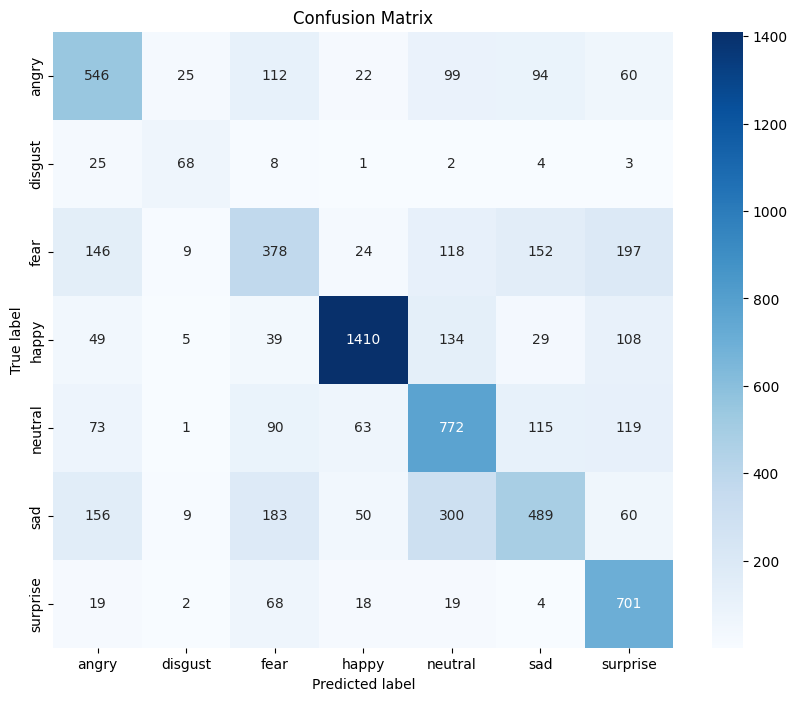

In [ ]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# Printing the classification report
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.54      0.57      0.55       958
     disgust       0.57      0.61      0.59       111
        fear       0.43      0.37      0.40      1024
       happy       0.89      0.79      0.84      1774
     neutral       0.53      0.63      0.58      1233
         sad       0.55      0.39      0.46      1247
    surprise       0.56      0.84      0.67       831

    accuracy                           0.61      7178
   macro avg       0.58      0.60      0.58      7178
weighted avg       0.61      0.61      0.60      7178



# AUC ROC plot for each class

In [ ]:
true_labels = test_generator.classes
preds = model.predict(test_generator, steps=len(test_generator))
pred_labels = np.argmax(preds, axis=1)
classes=list(test_generator.class_indices.keys())

113/113 [==============================] - 19s 166ms/step


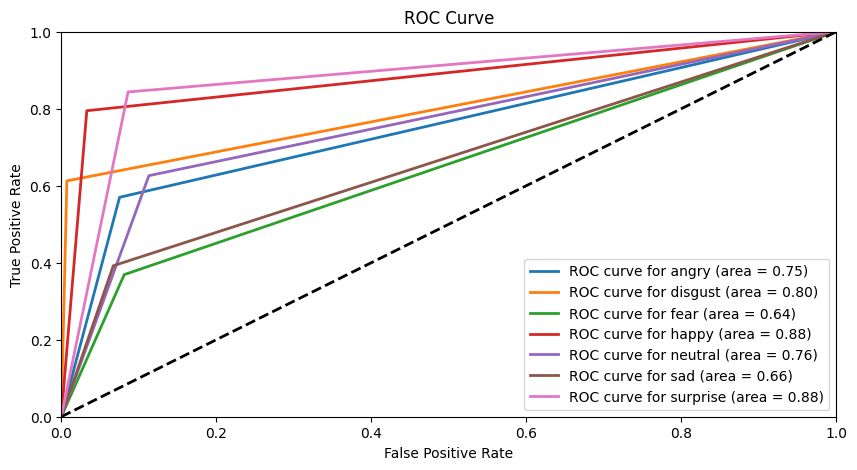

In [ ]:
y_encoded = pd.get_dummies(true_labels).astype(int).values
preds_encoded = pd.get_dummies(pred_labels).astype(int).values

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_encoded[:,i], preds_encoded[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10,5))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f"ROC curve for {classes[i]} (area = {roc_auc[i]:0.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

In [ ]:
model.save("Resnet_model_version_2.keras")

# Push all your models into Drive for easy access.

In [ ]:
!cp /content/FER_2013_Emotion_Detection /content/drive/MyDrive/

## If you are here and followed and learned everything, you are in a great positon to build a project at a industry standard level. Kudos to you!!
## All that's left is Deployement

# Deployement

# Gradio

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip3 install gradio

In [2]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install opencv-python


Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import gradio as gr
import gradio as gr
import tensorflow as tf
import numpy as np
from PIL import Image
import cv2
from tensorflow.keras.preprocessing import image

In [5]:
pip install my_custom_module


Note: you may need to restart the kernel to use updated packages.


In [8]:
import sys
sys.path.append('/path/to/custom_module')


In [9]:
import sys
print(sys.path)


['/Users/aakanksha/Desktop/Emotion Detection Materials', '/Users/aakanksha/miniforge3/lib/python310.zip', '/Users/aakanksha/miniforge3/lib/python3.10', '/Users/aakanksha/miniforge3/lib/python3.10/lib-dynload', '', '/Users/aakanksha/miniforge3/lib/python3.10/site-packages', '/Users/aakanksha/miniforge3/lib/python3.10/site-packages/cnnClassifier-0.0.0-py3.10.egg', '/path/to/custom_module']


ModuleNotFoundError: No module named 'my_custom_module'

In [10]:
from tensorflow import keras
from my_custom_module import MyCustomLayer, MyCustomLoss

# Define custom objects
custom_objects = {
    'MyCustomLayer': MyCustomLayer,
    'MyCustomLoss': MyCustomLoss
}

# Load model with custom objects
model = keras.models.load_model('/Users/aakanksha/Desktop/Emotion Detection Materials/Emotion Detection Deployement/Final_Resnet50_Best_model.keras', custom_objects=custom_objects)



ModuleNotFoundError: No module named 'my_custom_module'

In [9]:
# Ensure your model is loaded here
# model = ... # Load your trained model
# Load your pre-trained model
model = tf.keras.models.load_model('/Users/aakanksha/Desktop/Emotion Detection Materials/Emotion Detection Deployement/Final_Resnet50_Best_model.keras')

TypeError: <class 'keras.src.models.sequential.Sequential'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras', 'class_name': 'Sequential', 'config': {'name': 'sequential', 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': [None, 224, 224, 3], 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'resnet50v2_input'}, 'registered_name': None}, {'module': 'keras.src.engine.functional', 'class_name': 'Functional', 'config': {'name': 'resnet50v2', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': [None, 224, 224, 3], 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_1'}, 'registered_name': None, 'name': 'input_1', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'conv1_pad', 'trainable': False, 'dtype': 'float32', 'padding': [[3, 3], [3, 3]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 224, 224, 3]}, 'name': 'conv1_pad', 'inbound_nodes': [[['input_1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv1_conv', 'trainable': False, 'dtype': 'float32', 'filters': 64, 'kernel_size': [7, 7], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 230, 230, 3]}, 'name': 'conv1_conv', 'inbound_nodes': [[['conv1_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'pool1_pad', 'trainable': False, 'dtype': 'float32', 'padding': [[1, 1], [1, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 112, 112, 64]}, 'name': 'pool1_pad', 'inbound_nodes': [[['conv1_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'pool1_pool', 'trainable': False, 'dtype': 'float32', 'pool_size': [3, 3], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 114, 114, 64]}, 'name': 'pool1_pool', 'inbound_nodes': [[['pool1_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv2_block1_preact_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 'conv2_block1_preact_bn', 'inbound_nodes': [[['pool1_pool', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv2_block1_preact_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 'conv2_block1_preact_relu', 'inbound_nodes': [[['conv2_block1_preact_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2_block1_1_conv', 'trainable': False, 'dtype': 'float32', 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 'conv2_block1_1_conv', 'inbound_nodes': [[['conv2_block1_preact_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv2_block1_1_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 'conv2_block1_1_bn', 'inbound_nodes': [[['conv2_block1_1_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv2_block1_1_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 'conv2_block1_1_relu', 'inbound_nodes': [[['conv2_block1_1_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'conv2_block1_2_pad', 'trainable': False, 'dtype': 'float32', 'padding': [[1, 1], [1, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 'conv2_block1_2_pad', 'inbound_nodes': [[['conv2_block1_1_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2_block1_2_conv', 'trainable': False, 'dtype': 'float32', 'filters': 64, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 58, 58, 64]}, 'name': 'conv2_block1_2_conv', 'inbound_nodes': [[['conv2_block1_2_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv2_block1_2_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 'conv2_block1_2_bn', 'inbound_nodes': [[['conv2_block1_2_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv2_block1_2_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 'conv2_block1_2_relu', 'inbound_nodes': [[['conv2_block1_2_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2_block1_0_conv', 'trainable': False, 'dtype': 'float32', 'filters': 256, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 'conv2_block1_0_conv', 'inbound_nodes': [[['conv2_block1_preact_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2_block1_3_conv', 'trainable': False, 'dtype': 'float32', 'filters': 256, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 'conv2_block1_3_conv', 'inbound_nodes': [[['conv2_block1_2_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'conv2_block1_out', 'trainable': False, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 56, 56, 256], [None, 56, 56, 256]]}, 'name': 'conv2_block1_out', 'inbound_nodes': [[['conv2_block1_0_conv', 0, 0, {}], ['conv2_block1_3_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv2_block2_preact_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 256]}, 'name': 'conv2_block2_preact_bn', 'inbound_nodes': [[['conv2_block1_out', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv2_block2_preact_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 256]}, 'name': 'conv2_block2_preact_relu', 'inbound_nodes': [[['conv2_block2_preact_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2_block2_1_conv', 'trainable': False, 'dtype': 'float32', 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 256]}, 'name': 'conv2_block2_1_conv', 'inbound_nodes': [[['conv2_block2_preact_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv2_block2_1_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 'conv2_block2_1_bn', 'inbound_nodes': [[['conv2_block2_1_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv2_block2_1_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 'conv2_block2_1_relu', 'inbound_nodes': [[['conv2_block2_1_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'conv2_block2_2_pad', 'trainable': False, 'dtype': 'float32', 'padding': [[1, 1], [1, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 'conv2_block2_2_pad', 'inbound_nodes': [[['conv2_block2_1_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2_block2_2_conv', 'trainable': False, 'dtype': 'float32', 'filters': 64, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 58, 58, 64]}, 'name': 'conv2_block2_2_conv', 'inbound_nodes': [[['conv2_block2_2_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv2_block2_2_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 'conv2_block2_2_bn', 'inbound_nodes': [[['conv2_block2_2_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv2_block2_2_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 'conv2_block2_2_relu', 'inbound_nodes': [[['conv2_block2_2_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2_block2_3_conv', 'trainable': False, 'dtype': 'float32', 'filters': 256, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 'conv2_block2_3_conv', 'inbound_nodes': [[['conv2_block2_2_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'conv2_block2_out', 'trainable': False, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 56, 56, 256], [None, 56, 56, 256]]}, 'name': 'conv2_block2_out', 'inbound_nodes': [[['conv2_block1_out', 0, 0, {}], ['conv2_block2_3_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv2_block3_preact_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 256]}, 'name': 'conv2_block3_preact_bn', 'inbound_nodes': [[['conv2_block2_out', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv2_block3_preact_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 256]}, 'name': 'conv2_block3_preact_relu', 'inbound_nodes': [[['conv2_block3_preact_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2_block3_1_conv', 'trainable': False, 'dtype': 'float32', 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 256]}, 'name': 'conv2_block3_1_conv', 'inbound_nodes': [[['conv2_block3_preact_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv2_block3_1_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 'conv2_block3_1_bn', 'inbound_nodes': [[['conv2_block3_1_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv2_block3_1_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 'conv2_block3_1_relu', 'inbound_nodes': [[['conv2_block3_1_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'conv2_block3_2_pad', 'trainable': False, 'dtype': 'float32', 'padding': [[1, 1], [1, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 'conv2_block3_2_pad', 'inbound_nodes': [[['conv2_block3_1_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2_block3_2_conv', 'trainable': False, 'dtype': 'float32', 'filters': 64, 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 58, 58, 64]}, 'name': 'conv2_block3_2_conv', 'inbound_nodes': [[['conv2_block3_2_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv2_block3_2_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 64]}, 'name': 'conv2_block3_2_bn', 'inbound_nodes': [[['conv2_block3_2_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv2_block3_2_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 64]}, 'name': 'conv2_block3_2_relu', 'inbound_nodes': [[['conv2_block3_2_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d', 'trainable': False, 'dtype': 'float32', 'pool_size': [1, 1], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 256]}, 'name': 'max_pooling2d', 'inbound_nodes': [[['conv2_block2_out', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2_block3_3_conv', 'trainable': False, 'dtype': 'float32', 'filters': 256, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 64]}, 'name': 'conv2_block3_3_conv', 'inbound_nodes': [[['conv2_block3_2_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'conv2_block3_out', 'trainable': False, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 28, 28, 256], [None, 28, 28, 256]]}, 'name': 'conv2_block3_out', 'inbound_nodes': [[['max_pooling2d', 0, 0, {}], ['conv2_block3_3_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv3_block1_preact_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 256]}, 'name': 'conv3_block1_preact_bn', 'inbound_nodes': [[['conv2_block3_out', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv3_block1_preact_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 256]}, 'name': 'conv3_block1_preact_relu', 'inbound_nodes': [[['conv3_block1_preact_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv3_block1_1_conv', 'trainable': False, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 256]}, 'name': 'conv3_block1_1_conv', 'inbound_nodes': [[['conv3_block1_preact_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv3_block1_1_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block1_1_bn', 'inbound_nodes': [[['conv3_block1_1_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv3_block1_1_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block1_1_relu', 'inbound_nodes': [[['conv3_block1_1_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'conv3_block1_2_pad', 'trainable': False, 'dtype': 'float32', 'padding': [[1, 1], [1, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block1_2_pad', 'inbound_nodes': [[['conv3_block1_1_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv3_block1_2_conv', 'trainable': False, 'dtype': 'float32', 'filters': 128, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 30, 30, 128]}, 'name': 'conv3_block1_2_conv', 'inbound_nodes': [[['conv3_block1_2_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv3_block1_2_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block1_2_bn', 'inbound_nodes': [[['conv3_block1_2_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv3_block1_2_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block1_2_relu', 'inbound_nodes': [[['conv3_block1_2_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv3_block1_0_conv', 'trainable': False, 'dtype': 'float32', 'filters': 512, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 256]}, 'name': 'conv3_block1_0_conv', 'inbound_nodes': [[['conv3_block1_preact_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv3_block1_3_conv', 'trainable': False, 'dtype': 'float32', 'filters': 512, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block1_3_conv', 'inbound_nodes': [[['conv3_block1_2_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'conv3_block1_out', 'trainable': False, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 28, 28, 512], [None, 28, 28, 512]]}, 'name': 'conv3_block1_out', 'inbound_nodes': [[['conv3_block1_0_conv', 0, 0, {}], ['conv3_block1_3_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv3_block2_preact_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 512]}, 'name': 'conv3_block2_preact_bn', 'inbound_nodes': [[['conv3_block1_out', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv3_block2_preact_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 512]}, 'name': 'conv3_block2_preact_relu', 'inbound_nodes': [[['conv3_block2_preact_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv3_block2_1_conv', 'trainable': False, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 512]}, 'name': 'conv3_block2_1_conv', 'inbound_nodes': [[['conv3_block2_preact_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv3_block2_1_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block2_1_bn', 'inbound_nodes': [[['conv3_block2_1_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv3_block2_1_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block2_1_relu', 'inbound_nodes': [[['conv3_block2_1_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'conv3_block2_2_pad', 'trainable': False, 'dtype': 'float32', 'padding': [[1, 1], [1, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block2_2_pad', 'inbound_nodes': [[['conv3_block2_1_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv3_block2_2_conv', 'trainable': False, 'dtype': 'float32', 'filters': 128, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 30, 30, 128]}, 'name': 'conv3_block2_2_conv', 'inbound_nodes': [[['conv3_block2_2_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv3_block2_2_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block2_2_bn', 'inbound_nodes': [[['conv3_block2_2_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv3_block2_2_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block2_2_relu', 'inbound_nodes': [[['conv3_block2_2_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv3_block2_3_conv', 'trainable': False, 'dtype': 'float32', 'filters': 512, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block2_3_conv', 'inbound_nodes': [[['conv3_block2_2_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'conv3_block2_out', 'trainable': False, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 28, 28, 512], [None, 28, 28, 512]]}, 'name': 'conv3_block2_out', 'inbound_nodes': [[['conv3_block1_out', 0, 0, {}], ['conv3_block2_3_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv3_block3_preact_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 512]}, 'name': 'conv3_block3_preact_bn', 'inbound_nodes': [[['conv3_block2_out', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv3_block3_preact_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 512]}, 'name': 'conv3_block3_preact_relu', 'inbound_nodes': [[['conv3_block3_preact_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv3_block3_1_conv', 'trainable': False, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 512]}, 'name': 'conv3_block3_1_conv', 'inbound_nodes': [[['conv3_block3_preact_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv3_block3_1_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block3_1_bn', 'inbound_nodes': [[['conv3_block3_1_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv3_block3_1_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block3_1_relu', 'inbound_nodes': [[['conv3_block3_1_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'conv3_block3_2_pad', 'trainable': False, 'dtype': 'float32', 'padding': [[1, 1], [1, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block3_2_pad', 'inbound_nodes': [[['conv3_block3_1_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv3_block3_2_conv', 'trainable': False, 'dtype': 'float32', 'filters': 128, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 30, 30, 128]}, 'name': 'conv3_block3_2_conv', 'inbound_nodes': [[['conv3_block3_2_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv3_block3_2_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block3_2_bn', 'inbound_nodes': [[['conv3_block3_2_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv3_block3_2_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block3_2_relu', 'inbound_nodes': [[['conv3_block3_2_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv3_block3_3_conv', 'trainable': False, 'dtype': 'float32', 'filters': 512, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block3_3_conv', 'inbound_nodes': [[['conv3_block3_2_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'conv3_block3_out', 'trainable': False, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 28, 28, 512], [None, 28, 28, 512]]}, 'name': 'conv3_block3_out', 'inbound_nodes': [[['conv3_block2_out', 0, 0, {}], ['conv3_block3_3_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv3_block4_preact_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 512]}, 'name': 'conv3_block4_preact_bn', 'inbound_nodes': [[['conv3_block3_out', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv3_block4_preact_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 512]}, 'name': 'conv3_block4_preact_relu', 'inbound_nodes': [[['conv3_block4_preact_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv3_block4_1_conv', 'trainable': False, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 512]}, 'name': 'conv3_block4_1_conv', 'inbound_nodes': [[['conv3_block4_preact_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv3_block4_1_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block4_1_bn', 'inbound_nodes': [[['conv3_block4_1_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv3_block4_1_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block4_1_relu', 'inbound_nodes': [[['conv3_block4_1_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'conv3_block4_2_pad', 'trainable': False, 'dtype': 'float32', 'padding': [[1, 1], [1, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block4_2_pad', 'inbound_nodes': [[['conv3_block4_1_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv3_block4_2_conv', 'trainable': False, 'dtype': 'float32', 'filters': 128, 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 30, 30, 128]}, 'name': 'conv3_block4_2_conv', 'inbound_nodes': [[['conv3_block4_2_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv3_block4_2_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 128]}, 'name': 'conv3_block4_2_bn', 'inbound_nodes': [[['conv3_block4_2_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv3_block4_2_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 128]}, 'name': 'conv3_block4_2_relu', 'inbound_nodes': [[['conv3_block4_2_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d_1', 'trainable': False, 'dtype': 'float32', 'pool_size': [1, 1], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 512]}, 'name': 'max_pooling2d_1', 'inbound_nodes': [[['conv3_block3_out', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv3_block4_3_conv', 'trainable': False, 'dtype': 'float32', 'filters': 512, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 128]}, 'name': 'conv3_block4_3_conv', 'inbound_nodes': [[['conv3_block4_2_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'conv3_block4_out', 'trainable': False, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 14, 14, 512], [None, 14, 14, 512]]}, 'name': 'conv3_block4_out', 'inbound_nodes': [[['max_pooling2d_1', 0, 0, {}], ['conv3_block4_3_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv4_block1_preact_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}, 'name': 'conv4_block1_preact_bn', 'inbound_nodes': [[['conv3_block4_out', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv4_block1_preact_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}, 'name': 'conv4_block1_preact_relu', 'inbound_nodes': [[['conv4_block1_preact_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv4_block1_1_conv', 'trainable': False, 'dtype': 'float32', 'filters': 256, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}, 'name': 'conv4_block1_1_conv', 'inbound_nodes': [[['conv4_block1_preact_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv4_block1_1_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block1_1_bn', 'inbound_nodes': [[['conv4_block1_1_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv4_block1_1_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block1_1_relu', 'inbound_nodes': [[['conv4_block1_1_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'conv4_block1_2_pad', 'trainable': False, 'dtype': 'float32', 'padding': [[1, 1], [1, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block1_2_pad', 'inbound_nodes': [[['conv4_block1_1_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv4_block1_2_conv', 'trainable': False, 'dtype': 'float32', 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 16, 256]}, 'name': 'conv4_block1_2_conv', 'inbound_nodes': [[['conv4_block1_2_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv4_block1_2_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block1_2_bn', 'inbound_nodes': [[['conv4_block1_2_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv4_block1_2_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block1_2_relu', 'inbound_nodes': [[['conv4_block1_2_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv4_block1_0_conv', 'trainable': False, 'dtype': 'float32', 'filters': 1024, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}, 'name': 'conv4_block1_0_conv', 'inbound_nodes': [[['conv4_block1_preact_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv4_block1_3_conv', 'trainable': False, 'dtype': 'float32', 'filters': 1024, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block1_3_conv', 'inbound_nodes': [[['conv4_block1_2_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'conv4_block1_out', 'trainable': False, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 14, 14, 1024], [None, 14, 14, 1024]]}, 'name': 'conv4_block1_out', 'inbound_nodes': [[['conv4_block1_0_conv', 0, 0, {}], ['conv4_block1_3_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv4_block2_preact_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 1024]}, 'name': 'conv4_block2_preact_bn', 'inbound_nodes': [[['conv4_block1_out', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv4_block2_preact_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 1024]}, 'name': 'conv4_block2_preact_relu', 'inbound_nodes': [[['conv4_block2_preact_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv4_block2_1_conv', 'trainable': False, 'dtype': 'float32', 'filters': 256, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 1024]}, 'name': 'conv4_block2_1_conv', 'inbound_nodes': [[['conv4_block2_preact_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv4_block2_1_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block2_1_bn', 'inbound_nodes': [[['conv4_block2_1_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv4_block2_1_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block2_1_relu', 'inbound_nodes': [[['conv4_block2_1_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'conv4_block2_2_pad', 'trainable': False, 'dtype': 'float32', 'padding': [[1, 1], [1, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block2_2_pad', 'inbound_nodes': [[['conv4_block2_1_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv4_block2_2_conv', 'trainable': False, 'dtype': 'float32', 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 16, 256]}, 'name': 'conv4_block2_2_conv', 'inbound_nodes': [[['conv4_block2_2_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv4_block2_2_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block2_2_bn', 'inbound_nodes': [[['conv4_block2_2_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv4_block2_2_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block2_2_relu', 'inbound_nodes': [[['conv4_block2_2_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv4_block2_3_conv', 'trainable': False, 'dtype': 'float32', 'filters': 1024, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block2_3_conv', 'inbound_nodes': [[['conv4_block2_2_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'conv4_block2_out', 'trainable': False, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 14, 14, 1024], [None, 14, 14, 1024]]}, 'name': 'conv4_block2_out', 'inbound_nodes': [[['conv4_block1_out', 0, 0, {}], ['conv4_block2_3_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv4_block3_preact_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 1024]}, 'name': 'conv4_block3_preact_bn', 'inbound_nodes': [[['conv4_block2_out', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv4_block3_preact_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 1024]}, 'name': 'conv4_block3_preact_relu', 'inbound_nodes': [[['conv4_block3_preact_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv4_block3_1_conv', 'trainable': False, 'dtype': 'float32', 'filters': 256, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 1024]}, 'name': 'conv4_block3_1_conv', 'inbound_nodes': [[['conv4_block3_preact_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv4_block3_1_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block3_1_bn', 'inbound_nodes': [[['conv4_block3_1_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv4_block3_1_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block3_1_relu', 'inbound_nodes': [[['conv4_block3_1_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'conv4_block3_2_pad', 'trainable': False, 'dtype': 'float32', 'padding': [[1, 1], [1, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block3_2_pad', 'inbound_nodes': [[['conv4_block3_1_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv4_block3_2_conv', 'trainable': False, 'dtype': 'float32', 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 16, 256]}, 'name': 'conv4_block3_2_conv', 'inbound_nodes': [[['conv4_block3_2_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv4_block3_2_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block3_2_bn', 'inbound_nodes': [[['conv4_block3_2_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv4_block3_2_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block3_2_relu', 'inbound_nodes': [[['conv4_block3_2_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv4_block3_3_conv', 'trainable': False, 'dtype': 'float32', 'filters': 1024, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block3_3_conv', 'inbound_nodes': [[['conv4_block3_2_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'conv4_block3_out', 'trainable': False, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 14, 14, 1024], [None, 14, 14, 1024]]}, 'name': 'conv4_block3_out', 'inbound_nodes': [[['conv4_block2_out', 0, 0, {}], ['conv4_block3_3_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv4_block4_preact_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 1024]}, 'name': 'conv4_block4_preact_bn', 'inbound_nodes': [[['conv4_block3_out', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv4_block4_preact_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 1024]}, 'name': 'conv4_block4_preact_relu', 'inbound_nodes': [[['conv4_block4_preact_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv4_block4_1_conv', 'trainable': False, 'dtype': 'float32', 'filters': 256, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 1024]}, 'name': 'conv4_block4_1_conv', 'inbound_nodes': [[['conv4_block4_preact_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv4_block4_1_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block4_1_bn', 'inbound_nodes': [[['conv4_block4_1_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv4_block4_1_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block4_1_relu', 'inbound_nodes': [[['conv4_block4_1_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'conv4_block4_2_pad', 'trainable': False, 'dtype': 'float32', 'padding': [[1, 1], [1, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block4_2_pad', 'inbound_nodes': [[['conv4_block4_1_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv4_block4_2_conv', 'trainable': False, 'dtype': 'float32', 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 16, 256]}, 'name': 'conv4_block4_2_conv', 'inbound_nodes': [[['conv4_block4_2_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv4_block4_2_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block4_2_bn', 'inbound_nodes': [[['conv4_block4_2_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv4_block4_2_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block4_2_relu', 'inbound_nodes': [[['conv4_block4_2_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv4_block4_3_conv', 'trainable': False, 'dtype': 'float32', 'filters': 1024, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block4_3_conv', 'inbound_nodes': [[['conv4_block4_2_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'conv4_block4_out', 'trainable': False, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 14, 14, 1024], [None, 14, 14, 1024]]}, 'name': 'conv4_block4_out', 'inbound_nodes': [[['conv4_block3_out', 0, 0, {}], ['conv4_block4_3_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv4_block5_preact_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 1024]}, 'name': 'conv4_block5_preact_bn', 'inbound_nodes': [[['conv4_block4_out', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv4_block5_preact_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 1024]}, 'name': 'conv4_block5_preact_relu', 'inbound_nodes': [[['conv4_block5_preact_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv4_block5_1_conv', 'trainable': False, 'dtype': 'float32', 'filters': 256, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 1024]}, 'name': 'conv4_block5_1_conv', 'inbound_nodes': [[['conv4_block5_preact_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv4_block5_1_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block5_1_bn', 'inbound_nodes': [[['conv4_block5_1_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv4_block5_1_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block5_1_relu', 'inbound_nodes': [[['conv4_block5_1_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'conv4_block5_2_pad', 'trainable': False, 'dtype': 'float32', 'padding': [[1, 1], [1, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block5_2_pad', 'inbound_nodes': [[['conv4_block5_1_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv4_block5_2_conv', 'trainable': False, 'dtype': 'float32', 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 16, 256]}, 'name': 'conv4_block5_2_conv', 'inbound_nodes': [[['conv4_block5_2_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv4_block5_2_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block5_2_bn', 'inbound_nodes': [[['conv4_block5_2_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv4_block5_2_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block5_2_relu', 'inbound_nodes': [[['conv4_block5_2_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv4_block5_3_conv', 'trainable': True, 'dtype': 'float32', 'filters': 1024, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block5_3_conv', 'inbound_nodes': [[['conv4_block5_2_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'conv4_block5_out', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 14, 14, 1024], [None, 14, 14, 1024]]}, 'name': 'conv4_block5_out', 'inbound_nodes': [[['conv4_block4_out', 0, 0, {}], ['conv4_block5_3_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv4_block6_preact_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 1024]}, 'name': 'conv4_block6_preact_bn', 'inbound_nodes': [[['conv4_block5_out', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv4_block6_preact_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 1024]}, 'name': 'conv4_block6_preact_relu', 'inbound_nodes': [[['conv4_block6_preact_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv4_block6_1_conv', 'trainable': True, 'dtype': 'float32', 'filters': 256, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 1024]}, 'name': 'conv4_block6_1_conv', 'inbound_nodes': [[['conv4_block6_preact_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv4_block6_1_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block6_1_bn', 'inbound_nodes': [[['conv4_block6_1_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv4_block6_1_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block6_1_relu', 'inbound_nodes': [[['conv4_block6_1_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'conv4_block6_2_pad', 'trainable': True, 'dtype': 'float32', 'padding': [[1, 1], [1, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block6_2_pad', 'inbound_nodes': [[['conv4_block6_1_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv4_block6_2_conv', 'trainable': True, 'dtype': 'float32', 'filters': 256, 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 16, 256]}, 'name': 'conv4_block6_2_conv', 'inbound_nodes': [[['conv4_block6_2_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv4_block6_2_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 256]}, 'name': 'conv4_block6_2_bn', 'inbound_nodes': [[['conv4_block6_2_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv4_block6_2_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 256]}, 'name': 'conv4_block6_2_relu', 'inbound_nodes': [[['conv4_block6_2_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d_2', 'trainable': True, 'dtype': 'float32', 'pool_size': [1, 1], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 1024]}, 'name': 'max_pooling2d_2', 'inbound_nodes': [[['conv4_block5_out', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv4_block6_3_conv', 'trainable': True, 'dtype': 'float32', 'filters': 1024, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 256]}, 'name': 'conv4_block6_3_conv', 'inbound_nodes': [[['conv4_block6_2_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'conv4_block6_out', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 7, 7, 1024], [None, 7, 7, 1024]]}, 'name': 'conv4_block6_out', 'inbound_nodes': [[['max_pooling2d_2', 0, 0, {}], ['conv4_block6_3_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv5_block1_preact_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 1024]}, 'name': 'conv5_block1_preact_bn', 'inbound_nodes': [[['conv4_block6_out', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv5_block1_preact_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 1024]}, 'name': 'conv5_block1_preact_relu', 'inbound_nodes': [[['conv5_block1_preact_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv5_block1_1_conv', 'trainable': True, 'dtype': 'float32', 'filters': 512, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 1024]}, 'name': 'conv5_block1_1_conv', 'inbound_nodes': [[['conv5_block1_preact_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv5_block1_1_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 512]}, 'name': 'conv5_block1_1_bn', 'inbound_nodes': [[['conv5_block1_1_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv5_block1_1_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 512]}, 'name': 'conv5_block1_1_relu', 'inbound_nodes': [[['conv5_block1_1_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'conv5_block1_2_pad', 'trainable': True, 'dtype': 'float32', 'padding': [[1, 1], [1, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 512]}, 'name': 'conv5_block1_2_pad', 'inbound_nodes': [[['conv5_block1_1_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv5_block1_2_conv', 'trainable': True, 'dtype': 'float32', 'filters': 512, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 9, 9, 512]}, 'name': 'conv5_block1_2_conv', 'inbound_nodes': [[['conv5_block1_2_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv5_block1_2_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 512]}, 'name': 'conv5_block1_2_bn', 'inbound_nodes': [[['conv5_block1_2_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv5_block1_2_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 512]}, 'name': 'conv5_block1_2_relu', 'inbound_nodes': [[['conv5_block1_2_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv5_block1_0_conv', 'trainable': True, 'dtype': 'float32', 'filters': 2048, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 1024]}, 'name': 'conv5_block1_0_conv', 'inbound_nodes': [[['conv5_block1_preact_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv5_block1_3_conv', 'trainable': True, 'dtype': 'float32', 'filters': 2048, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 512]}, 'name': 'conv5_block1_3_conv', 'inbound_nodes': [[['conv5_block1_2_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'conv5_block1_out', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 7, 7, 2048], [None, 7, 7, 2048]]}, 'name': 'conv5_block1_out', 'inbound_nodes': [[['conv5_block1_0_conv', 0, 0, {}], ['conv5_block1_3_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv5_block2_preact_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 2048]}, 'name': 'conv5_block2_preact_bn', 'inbound_nodes': [[['conv5_block1_out', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv5_block2_preact_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 2048]}, 'name': 'conv5_block2_preact_relu', 'inbound_nodes': [[['conv5_block2_preact_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv5_block2_1_conv', 'trainable': True, 'dtype': 'float32', 'filters': 512, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 2048]}, 'name': 'conv5_block2_1_conv', 'inbound_nodes': [[['conv5_block2_preact_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv5_block2_1_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 512]}, 'name': 'conv5_block2_1_bn', 'inbound_nodes': [[['conv5_block2_1_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv5_block2_1_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 512]}, 'name': 'conv5_block2_1_relu', 'inbound_nodes': [[['conv5_block2_1_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'conv5_block2_2_pad', 'trainable': True, 'dtype': 'float32', 'padding': [[1, 1], [1, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 512]}, 'name': 'conv5_block2_2_pad', 'inbound_nodes': [[['conv5_block2_1_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv5_block2_2_conv', 'trainable': True, 'dtype': 'float32', 'filters': 512, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 9, 9, 512]}, 'name': 'conv5_block2_2_conv', 'inbound_nodes': [[['conv5_block2_2_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv5_block2_2_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 512]}, 'name': 'conv5_block2_2_bn', 'inbound_nodes': [[['conv5_block2_2_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv5_block2_2_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 512]}, 'name': 'conv5_block2_2_relu', 'inbound_nodes': [[['conv5_block2_2_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv5_block2_3_conv', 'trainable': True, 'dtype': 'float32', 'filters': 2048, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 512]}, 'name': 'conv5_block2_3_conv', 'inbound_nodes': [[['conv5_block2_2_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'conv5_block2_out', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 7, 7, 2048], [None, 7, 7, 2048]]}, 'name': 'conv5_block2_out', 'inbound_nodes': [[['conv5_block1_out', 0, 0, {}], ['conv5_block2_3_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv5_block3_preact_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 2048]}, 'name': 'conv5_block3_preact_bn', 'inbound_nodes': [[['conv5_block2_out', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv5_block3_preact_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 2048]}, 'name': 'conv5_block3_preact_relu', 'inbound_nodes': [[['conv5_block3_preact_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv5_block3_1_conv', 'trainable': True, 'dtype': 'float32', 'filters': 512, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 2048]}, 'name': 'conv5_block3_1_conv', 'inbound_nodes': [[['conv5_block3_preact_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv5_block3_1_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 512]}, 'name': 'conv5_block3_1_bn', 'inbound_nodes': [[['conv5_block3_1_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv5_block3_1_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 512]}, 'name': 'conv5_block3_1_relu', 'inbound_nodes': [[['conv5_block3_1_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'conv5_block3_2_pad', 'trainable': True, 'dtype': 'float32', 'padding': [[1, 1], [1, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 512]}, 'name': 'conv5_block3_2_pad', 'inbound_nodes': [[['conv5_block3_1_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv5_block3_2_conv', 'trainable': True, 'dtype': 'float32', 'filters': 512, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 9, 9, 512]}, 'name': 'conv5_block3_2_conv', 'inbound_nodes': [[['conv5_block3_2_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv5_block3_2_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 512]}, 'name': 'conv5_block3_2_bn', 'inbound_nodes': [[['conv5_block3_2_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv5_block3_2_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 512]}, 'name': 'conv5_block3_2_relu', 'inbound_nodes': [[['conv5_block3_2_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv5_block3_3_conv', 'trainable': True, 'dtype': 'float32', 'filters': 2048, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 512]}, 'name': 'conv5_block3_3_conv', 'inbound_nodes': [[['conv5_block3_2_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'conv5_block3_out', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 7, 7, 2048], [None, 7, 7, 2048]]}, 'name': 'conv5_block3_out', 'inbound_nodes': [[['conv5_block2_out', 0, 0, {}], ['conv5_block3_3_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'post_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 2048]}, 'name': 'post_bn', 'inbound_nodes': [[['conv5_block3_out', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'post_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 2048]}, 'name': 'post_relu', 'inbound_nodes': [[['post_bn', 0, 0, {}]]]}], 'input_layers': [['input_1', 0, 0]], 'output_layers': [['post_relu', 0, 0]]}, 'registered_name': 'Functional', 'build_config': {'input_shape': [None, 224, 224, 3]}}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout', 'trainable': True, 'dtype': 'float32', 'rate': 0.25, 'noise_shape': None, 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 2048]}}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 2048]}}, {'module': 'keras.layers', 'class_name': 'Flatten', 'config': {'name': 'flatten', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 2048]}}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense', 'trainable': True, 'dtype': 'float32', 'units': 64, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 100352]}}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_1', 'trainable': True, 'dtype': 'float32', 'axis': [1], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64]}}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_1', 'trainable': True, 'dtype': 'float32', 'rate': 0.5, 'noise_shape': None, 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64]}}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_1', 'trainable': True, 'dtype': 'float32', 'units': 7, 'activation': 'softmax', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64]}}]}, 'registered_name': None, 'build_config': {'input_shape': [None, 224, 224, 3]}, 'compile_config': {'optimizer': 'adam', 'loss': 'categorical_crossentropy', 'metrics': ['accuracy'], 'loss_weights': None, 'weighted_metrics': None, 'run_eagerly': None, 'steps_per_execution': None, 'jit_compile': None}}.

Exception encountered: Could not deserialize class 'Functional' because its parent module keras.src.engine.functional cannot be imported. Full object config: {'module': 'keras.src.engine.functional', 'class_name': 'Functional', 'config': {'name': 'resnet50v2', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': [None, 224, 224, 3], 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_1'}, 'registered_name': None, 'name': 'input_1', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'conv1_pad', 'trainable': False, 'dtype': 'float32', 'padding': [[3, 3], [3, 3]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 224, 224, 3]}, 'name': 'conv1_pad', 'inbound_nodes': [[['input_1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv1_conv', 'trainable': False, 'dtype': 'float32', 'filters': 64, 'kernel_size': [7, 7], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 230, 230, 3]}, 'name': 'conv1_conv', 'inbound_nodes': [[['conv1_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'pool1_pad', 'trainable': False, 'dtype': 'float32', 'padding': [[1, 1], [1, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 112, 112, 64]}, 'name': 'pool1_pad', 'inbound_nodes': [[['conv1_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'pool1_pool', 'trainable': False, 'dtype': 'float32', 'pool_size': [3, 3], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 114, 114, 64]}, 'name': 'pool1_pool', 'inbound_nodes': [[['pool1_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv2_block1_preact_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 'conv2_block1_preact_bn', 'inbound_nodes': [[['pool1_pool', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv2_block1_preact_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 'conv2_block1_preact_relu', 'inbound_nodes': [[['conv2_block1_preact_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2_block1_1_conv', 'trainable': False, 'dtype': 'float32', 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 'conv2_block1_1_conv', 'inbound_nodes': [[['conv2_block1_preact_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv2_block1_1_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 'conv2_block1_1_bn', 'inbound_nodes': [[['conv2_block1_1_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv2_block1_1_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 'conv2_block1_1_relu', 'inbound_nodes': [[['conv2_block1_1_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'conv2_block1_2_pad', 'trainable': False, 'dtype': 'float32', 'padding': [[1, 1], [1, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 'conv2_block1_2_pad', 'inbound_nodes': [[['conv2_block1_1_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2_block1_2_conv', 'trainable': False, 'dtype': 'float32', 'filters': 64, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 58, 58, 64]}, 'name': 'conv2_block1_2_conv', 'inbound_nodes': [[['conv2_block1_2_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv2_block1_2_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 'conv2_block1_2_bn', 'inbound_nodes': [[['conv2_block1_2_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv2_block1_2_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 'conv2_block1_2_relu', 'inbound_nodes': [[['conv2_block1_2_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2_block1_0_conv', 'trainable': False, 'dtype': 'float32', 'filters': 256, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 'conv2_block1_0_conv', 'inbound_nodes': [[['conv2_block1_preact_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2_block1_3_conv', 'trainable': False, 'dtype': 'float32', 'filters': 256, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 'conv2_block1_3_conv', 'inbound_nodes': [[['conv2_block1_2_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'conv2_block1_out', 'trainable': False, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 56, 56, 256], [None, 56, 56, 256]]}, 'name': 'conv2_block1_out', 'inbound_nodes': [[['conv2_block1_0_conv', 0, 0, {}], ['conv2_block1_3_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv2_block2_preact_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 256]}, 'name': 'conv2_block2_preact_bn', 'inbound_nodes': [[['conv2_block1_out', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv2_block2_preact_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 256]}, 'name': 'conv2_block2_preact_relu', 'inbound_nodes': [[['conv2_block2_preact_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2_block2_1_conv', 'trainable': False, 'dtype': 'float32', 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 256]}, 'name': 'conv2_block2_1_conv', 'inbound_nodes': [[['conv2_block2_preact_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv2_block2_1_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 'conv2_block2_1_bn', 'inbound_nodes': [[['conv2_block2_1_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv2_block2_1_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 'conv2_block2_1_relu', 'inbound_nodes': [[['conv2_block2_1_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'conv2_block2_2_pad', 'trainable': False, 'dtype': 'float32', 'padding': [[1, 1], [1, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 'conv2_block2_2_pad', 'inbound_nodes': [[['conv2_block2_1_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2_block2_2_conv', 'trainable': False, 'dtype': 'float32', 'filters': 64, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 58, 58, 64]}, 'name': 'conv2_block2_2_conv', 'inbound_nodes': [[['conv2_block2_2_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv2_block2_2_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 'conv2_block2_2_bn', 'inbound_nodes': [[['conv2_block2_2_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv2_block2_2_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 'conv2_block2_2_relu', 'inbound_nodes': [[['conv2_block2_2_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2_block2_3_conv', 'trainable': False, 'dtype': 'float32', 'filters': 256, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 'conv2_block2_3_conv', 'inbound_nodes': [[['conv2_block2_2_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'conv2_block2_out', 'trainable': False, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 56, 56, 256], [None, 56, 56, 256]]}, 'name': 'conv2_block2_out', 'inbound_nodes': [[['conv2_block1_out', 0, 0, {}], ['conv2_block2_3_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv2_block3_preact_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 256]}, 'name': 'conv2_block3_preact_bn', 'inbound_nodes': [[['conv2_block2_out', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv2_block3_preact_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 256]}, 'name': 'conv2_block3_preact_relu', 'inbound_nodes': [[['conv2_block3_preact_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2_block3_1_conv', 'trainable': False, 'dtype': 'float32', 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 256]}, 'name': 'conv2_block3_1_conv', 'inbound_nodes': [[['conv2_block3_preact_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv2_block3_1_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 'conv2_block3_1_bn', 'inbound_nodes': [[['conv2_block3_1_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv2_block3_1_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 'conv2_block3_1_relu', 'inbound_nodes': [[['conv2_block3_1_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'conv2_block3_2_pad', 'trainable': False, 'dtype': 'float32', 'padding': [[1, 1], [1, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 'conv2_block3_2_pad', 'inbound_nodes': [[['conv2_block3_1_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2_block3_2_conv', 'trainable': False, 'dtype': 'float32', 'filters': 64, 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 58, 58, 64]}, 'name': 'conv2_block3_2_conv', 'inbound_nodes': [[['conv2_block3_2_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv2_block3_2_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 64]}, 'name': 'conv2_block3_2_bn', 'inbound_nodes': [[['conv2_block3_2_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv2_block3_2_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 64]}, 'name': 'conv2_block3_2_relu', 'inbound_nodes': [[['conv2_block3_2_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d', 'trainable': False, 'dtype': 'float32', 'pool_size': [1, 1], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 256]}, 'name': 'max_pooling2d', 'inbound_nodes': [[['conv2_block2_out', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2_block3_3_conv', 'trainable': False, 'dtype': 'float32', 'filters': 256, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 64]}, 'name': 'conv2_block3_3_conv', 'inbound_nodes': [[['conv2_block3_2_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'conv2_block3_out', 'trainable': False, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 28, 28, 256], [None, 28, 28, 256]]}, 'name': 'conv2_block3_out', 'inbound_nodes': [[['max_pooling2d', 0, 0, {}], ['conv2_block3_3_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv3_block1_preact_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 256]}, 'name': 'conv3_block1_preact_bn', 'inbound_nodes': [[['conv2_block3_out', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv3_block1_preact_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 256]}, 'name': 'conv3_block1_preact_relu', 'inbound_nodes': [[['conv3_block1_preact_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv3_block1_1_conv', 'trainable': False, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 256]}, 'name': 'conv3_block1_1_conv', 'inbound_nodes': [[['conv3_block1_preact_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv3_block1_1_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block1_1_bn', 'inbound_nodes': [[['conv3_block1_1_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv3_block1_1_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block1_1_relu', 'inbound_nodes': [[['conv3_block1_1_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'conv3_block1_2_pad', 'trainable': False, 'dtype': 'float32', 'padding': [[1, 1], [1, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block1_2_pad', 'inbound_nodes': [[['conv3_block1_1_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv3_block1_2_conv', 'trainable': False, 'dtype': 'float32', 'filters': 128, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 30, 30, 128]}, 'name': 'conv3_block1_2_conv', 'inbound_nodes': [[['conv3_block1_2_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv3_block1_2_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block1_2_bn', 'inbound_nodes': [[['conv3_block1_2_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv3_block1_2_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block1_2_relu', 'inbound_nodes': [[['conv3_block1_2_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv3_block1_0_conv', 'trainable': False, 'dtype': 'float32', 'filters': 512, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 256]}, 'name': 'conv3_block1_0_conv', 'inbound_nodes': [[['conv3_block1_preact_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv3_block1_3_conv', 'trainable': False, 'dtype': 'float32', 'filters': 512, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block1_3_conv', 'inbound_nodes': [[['conv3_block1_2_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'conv3_block1_out', 'trainable': False, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 28, 28, 512], [None, 28, 28, 512]]}, 'name': 'conv3_block1_out', 'inbound_nodes': [[['conv3_block1_0_conv', 0, 0, {}], ['conv3_block1_3_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv3_block2_preact_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 512]}, 'name': 'conv3_block2_preact_bn', 'inbound_nodes': [[['conv3_block1_out', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv3_block2_preact_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 512]}, 'name': 'conv3_block2_preact_relu', 'inbound_nodes': [[['conv3_block2_preact_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv3_block2_1_conv', 'trainable': False, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 512]}, 'name': 'conv3_block2_1_conv', 'inbound_nodes': [[['conv3_block2_preact_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv3_block2_1_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block2_1_bn', 'inbound_nodes': [[['conv3_block2_1_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv3_block2_1_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block2_1_relu', 'inbound_nodes': [[['conv3_block2_1_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'conv3_block2_2_pad', 'trainable': False, 'dtype': 'float32', 'padding': [[1, 1], [1, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block2_2_pad', 'inbound_nodes': [[['conv3_block2_1_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv3_block2_2_conv', 'trainable': False, 'dtype': 'float32', 'filters': 128, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 30, 30, 128]}, 'name': 'conv3_block2_2_conv', 'inbound_nodes': [[['conv3_block2_2_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv3_block2_2_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block2_2_bn', 'inbound_nodes': [[['conv3_block2_2_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv3_block2_2_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block2_2_relu', 'inbound_nodes': [[['conv3_block2_2_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv3_block2_3_conv', 'trainable': False, 'dtype': 'float32', 'filters': 512, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block2_3_conv', 'inbound_nodes': [[['conv3_block2_2_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'conv3_block2_out', 'trainable': False, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 28, 28, 512], [None, 28, 28, 512]]}, 'name': 'conv3_block2_out', 'inbound_nodes': [[['conv3_block1_out', 0, 0, {}], ['conv3_block2_3_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv3_block3_preact_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 512]}, 'name': 'conv3_block3_preact_bn', 'inbound_nodes': [[['conv3_block2_out', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv3_block3_preact_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 512]}, 'name': 'conv3_block3_preact_relu', 'inbound_nodes': [[['conv3_block3_preact_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv3_block3_1_conv', 'trainable': False, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 512]}, 'name': 'conv3_block3_1_conv', 'inbound_nodes': [[['conv3_block3_preact_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv3_block3_1_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block3_1_bn', 'inbound_nodes': [[['conv3_block3_1_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv3_block3_1_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block3_1_relu', 'inbound_nodes': [[['conv3_block3_1_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'conv3_block3_2_pad', 'trainable': False, 'dtype': 'float32', 'padding': [[1, 1], [1, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block3_2_pad', 'inbound_nodes': [[['conv3_block3_1_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv3_block3_2_conv', 'trainable': False, 'dtype': 'float32', 'filters': 128, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 30, 30, 128]}, 'name': 'conv3_block3_2_conv', 'inbound_nodes': [[['conv3_block3_2_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv3_block3_2_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block3_2_bn', 'inbound_nodes': [[['conv3_block3_2_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv3_block3_2_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block3_2_relu', 'inbound_nodes': [[['conv3_block3_2_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv3_block3_3_conv', 'trainable': False, 'dtype': 'float32', 'filters': 512, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block3_3_conv', 'inbound_nodes': [[['conv3_block3_2_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'conv3_block3_out', 'trainable': False, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 28, 28, 512], [None, 28, 28, 512]]}, 'name': 'conv3_block3_out', 'inbound_nodes': [[['conv3_block2_out', 0, 0, {}], ['conv3_block3_3_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv3_block4_preact_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 512]}, 'name': 'conv3_block4_preact_bn', 'inbound_nodes': [[['conv3_block3_out', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv3_block4_preact_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 512]}, 'name': 'conv3_block4_preact_relu', 'inbound_nodes': [[['conv3_block4_preact_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv3_block4_1_conv', 'trainable': False, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 512]}, 'name': 'conv3_block4_1_conv', 'inbound_nodes': [[['conv3_block4_preact_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv3_block4_1_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block4_1_bn', 'inbound_nodes': [[['conv3_block4_1_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv3_block4_1_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block4_1_relu', 'inbound_nodes': [[['conv3_block4_1_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'conv3_block4_2_pad', 'trainable': False, 'dtype': 'float32', 'padding': [[1, 1], [1, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block4_2_pad', 'inbound_nodes': [[['conv3_block4_1_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv3_block4_2_conv', 'trainable': False, 'dtype': 'float32', 'filters': 128, 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 30, 30, 128]}, 'name': 'conv3_block4_2_conv', 'inbound_nodes': [[['conv3_block4_2_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv3_block4_2_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 128]}, 'name': 'conv3_block4_2_bn', 'inbound_nodes': [[['conv3_block4_2_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv3_block4_2_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 128]}, 'name': 'conv3_block4_2_relu', 'inbound_nodes': [[['conv3_block4_2_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d_1', 'trainable': False, 'dtype': 'float32', 'pool_size': [1, 1], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 512]}, 'name': 'max_pooling2d_1', 'inbound_nodes': [[['conv3_block3_out', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv3_block4_3_conv', 'trainable': False, 'dtype': 'float32', 'filters': 512, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 128]}, 'name': 'conv3_block4_3_conv', 'inbound_nodes': [[['conv3_block4_2_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'conv3_block4_out', 'trainable': False, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 14, 14, 512], [None, 14, 14, 512]]}, 'name': 'conv3_block4_out', 'inbound_nodes': [[['max_pooling2d_1', 0, 0, {}], ['conv3_block4_3_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv4_block1_preact_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}, 'name': 'conv4_block1_preact_bn', 'inbound_nodes': [[['conv3_block4_out', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv4_block1_preact_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}, 'name': 'conv4_block1_preact_relu', 'inbound_nodes': [[['conv4_block1_preact_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv4_block1_1_conv', 'trainable': False, 'dtype': 'float32', 'filters': 256, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}, 'name': 'conv4_block1_1_conv', 'inbound_nodes': [[['conv4_block1_preact_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv4_block1_1_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block1_1_bn', 'inbound_nodes': [[['conv4_block1_1_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv4_block1_1_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block1_1_relu', 'inbound_nodes': [[['conv4_block1_1_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'conv4_block1_2_pad', 'trainable': False, 'dtype': 'float32', 'padding': [[1, 1], [1, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block1_2_pad', 'inbound_nodes': [[['conv4_block1_1_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv4_block1_2_conv', 'trainable': False, 'dtype': 'float32', 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 16, 256]}, 'name': 'conv4_block1_2_conv', 'inbound_nodes': [[['conv4_block1_2_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv4_block1_2_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block1_2_bn', 'inbound_nodes': [[['conv4_block1_2_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv4_block1_2_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block1_2_relu', 'inbound_nodes': [[['conv4_block1_2_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv4_block1_0_conv', 'trainable': False, 'dtype': 'float32', 'filters': 1024, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}, 'name': 'conv4_block1_0_conv', 'inbound_nodes': [[['conv4_block1_preact_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv4_block1_3_conv', 'trainable': False, 'dtype': 'float32', 'filters': 1024, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block1_3_conv', 'inbound_nodes': [[['conv4_block1_2_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'conv4_block1_out', 'trainable': False, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 14, 14, 1024], [None, 14, 14, 1024]]}, 'name': 'conv4_block1_out', 'inbound_nodes': [[['conv4_block1_0_conv', 0, 0, {}], ['conv4_block1_3_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv4_block2_preact_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 1024]}, 'name': 'conv4_block2_preact_bn', 'inbound_nodes': [[['conv4_block1_out', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv4_block2_preact_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 1024]}, 'name': 'conv4_block2_preact_relu', 'inbound_nodes': [[['conv4_block2_preact_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv4_block2_1_conv', 'trainable': False, 'dtype': 'float32', 'filters': 256, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 1024]}, 'name': 'conv4_block2_1_conv', 'inbound_nodes': [[['conv4_block2_preact_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv4_block2_1_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block2_1_bn', 'inbound_nodes': [[['conv4_block2_1_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv4_block2_1_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block2_1_relu', 'inbound_nodes': [[['conv4_block2_1_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'conv4_block2_2_pad', 'trainable': False, 'dtype': 'float32', 'padding': [[1, 1], [1, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block2_2_pad', 'inbound_nodes': [[['conv4_block2_1_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv4_block2_2_conv', 'trainable': False, 'dtype': 'float32', 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 16, 256]}, 'name': 'conv4_block2_2_conv', 'inbound_nodes': [[['conv4_block2_2_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv4_block2_2_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block2_2_bn', 'inbound_nodes': [[['conv4_block2_2_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv4_block2_2_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block2_2_relu', 'inbound_nodes': [[['conv4_block2_2_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv4_block2_3_conv', 'trainable': False, 'dtype': 'float32', 'filters': 1024, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block2_3_conv', 'inbound_nodes': [[['conv4_block2_2_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'conv4_block2_out', 'trainable': False, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 14, 14, 1024], [None, 14, 14, 1024]]}, 'name': 'conv4_block2_out', 'inbound_nodes': [[['conv4_block1_out', 0, 0, {}], ['conv4_block2_3_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv4_block3_preact_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 1024]}, 'name': 'conv4_block3_preact_bn', 'inbound_nodes': [[['conv4_block2_out', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv4_block3_preact_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 1024]}, 'name': 'conv4_block3_preact_relu', 'inbound_nodes': [[['conv4_block3_preact_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv4_block3_1_conv', 'trainable': False, 'dtype': 'float32', 'filters': 256, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 1024]}, 'name': 'conv4_block3_1_conv', 'inbound_nodes': [[['conv4_block3_preact_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv4_block3_1_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block3_1_bn', 'inbound_nodes': [[['conv4_block3_1_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv4_block3_1_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block3_1_relu', 'inbound_nodes': [[['conv4_block3_1_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'conv4_block3_2_pad', 'trainable': False, 'dtype': 'float32', 'padding': [[1, 1], [1, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block3_2_pad', 'inbound_nodes': [[['conv4_block3_1_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv4_block3_2_conv', 'trainable': False, 'dtype': 'float32', 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 16, 256]}, 'name': 'conv4_block3_2_conv', 'inbound_nodes': [[['conv4_block3_2_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv4_block3_2_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block3_2_bn', 'inbound_nodes': [[['conv4_block3_2_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv4_block3_2_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block3_2_relu', 'inbound_nodes': [[['conv4_block3_2_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv4_block3_3_conv', 'trainable': False, 'dtype': 'float32', 'filters': 1024, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block3_3_conv', 'inbound_nodes': [[['conv4_block3_2_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'conv4_block3_out', 'trainable': False, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 14, 14, 1024], [None, 14, 14, 1024]]}, 'name': 'conv4_block3_out', 'inbound_nodes': [[['conv4_block2_out', 0, 0, {}], ['conv4_block3_3_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv4_block4_preact_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 1024]}, 'name': 'conv4_block4_preact_bn', 'inbound_nodes': [[['conv4_block3_out', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv4_block4_preact_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 1024]}, 'name': 'conv4_block4_preact_relu', 'inbound_nodes': [[['conv4_block4_preact_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv4_block4_1_conv', 'trainable': False, 'dtype': 'float32', 'filters': 256, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 1024]}, 'name': 'conv4_block4_1_conv', 'inbound_nodes': [[['conv4_block4_preact_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv4_block4_1_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block4_1_bn', 'inbound_nodes': [[['conv4_block4_1_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv4_block4_1_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block4_1_relu', 'inbound_nodes': [[['conv4_block4_1_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'conv4_block4_2_pad', 'trainable': False, 'dtype': 'float32', 'padding': [[1, 1], [1, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block4_2_pad', 'inbound_nodes': [[['conv4_block4_1_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv4_block4_2_conv', 'trainable': False, 'dtype': 'float32', 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 16, 256]}, 'name': 'conv4_block4_2_conv', 'inbound_nodes': [[['conv4_block4_2_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv4_block4_2_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block4_2_bn', 'inbound_nodes': [[['conv4_block4_2_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv4_block4_2_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block4_2_relu', 'inbound_nodes': [[['conv4_block4_2_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv4_block4_3_conv', 'trainable': False, 'dtype': 'float32', 'filters': 1024, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block4_3_conv', 'inbound_nodes': [[['conv4_block4_2_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'conv4_block4_out', 'trainable': False, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 14, 14, 1024], [None, 14, 14, 1024]]}, 'name': 'conv4_block4_out', 'inbound_nodes': [[['conv4_block3_out', 0, 0, {}], ['conv4_block4_3_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv4_block5_preact_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 1024]}, 'name': 'conv4_block5_preact_bn', 'inbound_nodes': [[['conv4_block4_out', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv4_block5_preact_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 1024]}, 'name': 'conv4_block5_preact_relu', 'inbound_nodes': [[['conv4_block5_preact_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv4_block5_1_conv', 'trainable': False, 'dtype': 'float32', 'filters': 256, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 1024]}, 'name': 'conv4_block5_1_conv', 'inbound_nodes': [[['conv4_block5_preact_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv4_block5_1_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block5_1_bn', 'inbound_nodes': [[['conv4_block5_1_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv4_block5_1_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block5_1_relu', 'inbound_nodes': [[['conv4_block5_1_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'conv4_block5_2_pad', 'trainable': False, 'dtype': 'float32', 'padding': [[1, 1], [1, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block5_2_pad', 'inbound_nodes': [[['conv4_block5_1_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv4_block5_2_conv', 'trainable': False, 'dtype': 'float32', 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 16, 256]}, 'name': 'conv4_block5_2_conv', 'inbound_nodes': [[['conv4_block5_2_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv4_block5_2_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block5_2_bn', 'inbound_nodes': [[['conv4_block5_2_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv4_block5_2_relu', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block5_2_relu', 'inbound_nodes': [[['conv4_block5_2_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv4_block5_3_conv', 'trainable': True, 'dtype': 'float32', 'filters': 1024, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block5_3_conv', 'inbound_nodes': [[['conv4_block5_2_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'conv4_block5_out', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 14, 14, 1024], [None, 14, 14, 1024]]}, 'name': 'conv4_block5_out', 'inbound_nodes': [[['conv4_block4_out', 0, 0, {}], ['conv4_block5_3_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv4_block6_preact_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 1024]}, 'name': 'conv4_block6_preact_bn', 'inbound_nodes': [[['conv4_block5_out', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv4_block6_preact_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 1024]}, 'name': 'conv4_block6_preact_relu', 'inbound_nodes': [[['conv4_block6_preact_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv4_block6_1_conv', 'trainable': True, 'dtype': 'float32', 'filters': 256, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 1024]}, 'name': 'conv4_block6_1_conv', 'inbound_nodes': [[['conv4_block6_preact_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv4_block6_1_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block6_1_bn', 'inbound_nodes': [[['conv4_block6_1_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv4_block6_1_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block6_1_relu', 'inbound_nodes': [[['conv4_block6_1_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'conv4_block6_2_pad', 'trainable': True, 'dtype': 'float32', 'padding': [[1, 1], [1, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block6_2_pad', 'inbound_nodes': [[['conv4_block6_1_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv4_block6_2_conv', 'trainable': True, 'dtype': 'float32', 'filters': 256, 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 16, 256]}, 'name': 'conv4_block6_2_conv', 'inbound_nodes': [[['conv4_block6_2_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv4_block6_2_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 256]}, 'name': 'conv4_block6_2_bn', 'inbound_nodes': [[['conv4_block6_2_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv4_block6_2_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 256]}, 'name': 'conv4_block6_2_relu', 'inbound_nodes': [[['conv4_block6_2_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d_2', 'trainable': True, 'dtype': 'float32', 'pool_size': [1, 1], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 1024]}, 'name': 'max_pooling2d_2', 'inbound_nodes': [[['conv4_block5_out', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv4_block6_3_conv', 'trainable': True, 'dtype': 'float32', 'filters': 1024, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 256]}, 'name': 'conv4_block6_3_conv', 'inbound_nodes': [[['conv4_block6_2_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'conv4_block6_out', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 7, 7, 1024], [None, 7, 7, 1024]]}, 'name': 'conv4_block6_out', 'inbound_nodes': [[['max_pooling2d_2', 0, 0, {}], ['conv4_block6_3_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv5_block1_preact_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 1024]}, 'name': 'conv5_block1_preact_bn', 'inbound_nodes': [[['conv4_block6_out', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv5_block1_preact_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 1024]}, 'name': 'conv5_block1_preact_relu', 'inbound_nodes': [[['conv5_block1_preact_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv5_block1_1_conv', 'trainable': True, 'dtype': 'float32', 'filters': 512, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 1024]}, 'name': 'conv5_block1_1_conv', 'inbound_nodes': [[['conv5_block1_preact_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv5_block1_1_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 512]}, 'name': 'conv5_block1_1_bn', 'inbound_nodes': [[['conv5_block1_1_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv5_block1_1_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 512]}, 'name': 'conv5_block1_1_relu', 'inbound_nodes': [[['conv5_block1_1_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'conv5_block1_2_pad', 'trainable': True, 'dtype': 'float32', 'padding': [[1, 1], [1, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 512]}, 'name': 'conv5_block1_2_pad', 'inbound_nodes': [[['conv5_block1_1_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv5_block1_2_conv', 'trainable': True, 'dtype': 'float32', 'filters': 512, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 9, 9, 512]}, 'name': 'conv5_block1_2_conv', 'inbound_nodes': [[['conv5_block1_2_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv5_block1_2_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 512]}, 'name': 'conv5_block1_2_bn', 'inbound_nodes': [[['conv5_block1_2_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv5_block1_2_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 512]}, 'name': 'conv5_block1_2_relu', 'inbound_nodes': [[['conv5_block1_2_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv5_block1_0_conv', 'trainable': True, 'dtype': 'float32', 'filters': 2048, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 1024]}, 'name': 'conv5_block1_0_conv', 'inbound_nodes': [[['conv5_block1_preact_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv5_block1_3_conv', 'trainable': True, 'dtype': 'float32', 'filters': 2048, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 512]}, 'name': 'conv5_block1_3_conv', 'inbound_nodes': [[['conv5_block1_2_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'conv5_block1_out', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 7, 7, 2048], [None, 7, 7, 2048]]}, 'name': 'conv5_block1_out', 'inbound_nodes': [[['conv5_block1_0_conv', 0, 0, {}], ['conv5_block1_3_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv5_block2_preact_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 2048]}, 'name': 'conv5_block2_preact_bn', 'inbound_nodes': [[['conv5_block1_out', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv5_block2_preact_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 2048]}, 'name': 'conv5_block2_preact_relu', 'inbound_nodes': [[['conv5_block2_preact_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv5_block2_1_conv', 'trainable': True, 'dtype': 'float32', 'filters': 512, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 2048]}, 'name': 'conv5_block2_1_conv', 'inbound_nodes': [[['conv5_block2_preact_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv5_block2_1_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 512]}, 'name': 'conv5_block2_1_bn', 'inbound_nodes': [[['conv5_block2_1_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv5_block2_1_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 512]}, 'name': 'conv5_block2_1_relu', 'inbound_nodes': [[['conv5_block2_1_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'conv5_block2_2_pad', 'trainable': True, 'dtype': 'float32', 'padding': [[1, 1], [1, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 512]}, 'name': 'conv5_block2_2_pad', 'inbound_nodes': [[['conv5_block2_1_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv5_block2_2_conv', 'trainable': True, 'dtype': 'float32', 'filters': 512, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 9, 9, 512]}, 'name': 'conv5_block2_2_conv', 'inbound_nodes': [[['conv5_block2_2_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv5_block2_2_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 512]}, 'name': 'conv5_block2_2_bn', 'inbound_nodes': [[['conv5_block2_2_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv5_block2_2_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 512]}, 'name': 'conv5_block2_2_relu', 'inbound_nodes': [[['conv5_block2_2_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv5_block2_3_conv', 'trainable': True, 'dtype': 'float32', 'filters': 2048, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 512]}, 'name': 'conv5_block2_3_conv', 'inbound_nodes': [[['conv5_block2_2_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'conv5_block2_out', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 7, 7, 2048], [None, 7, 7, 2048]]}, 'name': 'conv5_block2_out', 'inbound_nodes': [[['conv5_block1_out', 0, 0, {}], ['conv5_block2_3_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv5_block3_preact_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 2048]}, 'name': 'conv5_block3_preact_bn', 'inbound_nodes': [[['conv5_block2_out', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv5_block3_preact_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 2048]}, 'name': 'conv5_block3_preact_relu', 'inbound_nodes': [[['conv5_block3_preact_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv5_block3_1_conv', 'trainable': True, 'dtype': 'float32', 'filters': 512, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 2048]}, 'name': 'conv5_block3_1_conv', 'inbound_nodes': [[['conv5_block3_preact_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv5_block3_1_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 512]}, 'name': 'conv5_block3_1_bn', 'inbound_nodes': [[['conv5_block3_1_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv5_block3_1_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 512]}, 'name': 'conv5_block3_1_relu', 'inbound_nodes': [[['conv5_block3_1_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'conv5_block3_2_pad', 'trainable': True, 'dtype': 'float32', 'padding': [[1, 1], [1, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 512]}, 'name': 'conv5_block3_2_pad', 'inbound_nodes': [[['conv5_block3_1_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv5_block3_2_conv', 'trainable': True, 'dtype': 'float32', 'filters': 512, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 9, 9, 512]}, 'name': 'conv5_block3_2_conv', 'inbound_nodes': [[['conv5_block3_2_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv5_block3_2_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 512]}, 'name': 'conv5_block3_2_bn', 'inbound_nodes': [[['conv5_block3_2_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv5_block3_2_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 512]}, 'name': 'conv5_block3_2_relu', 'inbound_nodes': [[['conv5_block3_2_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv5_block3_3_conv', 'trainable': True, 'dtype': 'float32', 'filters': 2048, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 512]}, 'name': 'conv5_block3_3_conv', 'inbound_nodes': [[['conv5_block3_2_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'conv5_block3_out', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 7, 7, 2048], [None, 7, 7, 2048]]}, 'name': 'conv5_block3_out', 'inbound_nodes': [[['conv5_block2_out', 0, 0, {}], ['conv5_block3_3_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'post_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 2048]}, 'name': 'post_bn', 'inbound_nodes': [[['conv5_block3_out', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'post_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 2048]}, 'name': 'post_relu', 'inbound_nodes': [[['post_bn', 0, 0, {}]]]}], 'input_layers': [['input_1', 0, 0]], 'output_layers': [['post_relu', 0, 0]]}, 'registered_name': 'Functional', 'build_config': {'input_shape': [None, 224, 224, 3]}}

In [7]:
# Emotion labels dictionary
emotion_labels = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
index_to_emotion = {v: k for k, v in emotion_labels.items()}
index_to_emotion

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

In [8]:
def prepare_image(img_pil):
    """Preprocess the PIL image to fit your model's input requirements."""
    # Convert the PIL image to a numpy array with the target size
    img = img_pil.resize((224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Convert single image to a batch.
    img_array /= 255.0  # Rescale pixel values to [0,1], as done during training
    return img_array



# Define the Gradio interface
def predict_emotion(image):
    # Preprocess the image
    processed_image = prepare_image(image)
    # Make prediction using the model
    prediction = model.predict(processed_image)
    # Get the emotion label with the highest probability
    predicted_class = np.argmax(prediction, axis=1)
    predicted_emotion = index_to_emotion.get(predicted_class[0], "Unknown Emotion")
    return predicted_emotion

interface = gr.Interface(
    fn=predict_emotion,  # Your prediction function
    inputs=gr.Image(type="pil"),  # Input for uploading an image, directly compatible with PIL images
    outputs="text",  # Output as text displaying the predicted emotion
    title="Emotion Detection",
    description="Upload an image and see the predicted emotion."
)

# Launch the Gradio interface
interface.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://eb53f8c30e2eca7f49.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
